# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.04449294, -0.21327739, -0.01225429,  0.26880974]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.570289819880813 -3.026688140247116


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [18]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    # loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
    #                                                               labels=tf.nn.sigmoid(Qs_labels)))    
    return actions_logits, loss

In [19]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [22]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [24]:
# Training parameters
batch_size = 500               # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [25]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [27]:
state, reward, action

(array([ 0.05272068, -0.26944343,  0.07353636,  0.8886292 ]), 1.0, 0)

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    
    # Training episodes/epochs
    for ep in range(111111111111111):
        state = env.reset()
        total_reward = 0
        loss_batch = []

        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states}) 
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episodes_total_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'loss:{:.4f}'.format(np.mean(loss_batch)))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:29.0000 loss:1.5087
Episode:1 meanR:19.5000 loss:1.9406
Episode:2 meanR:25.3333 loss:4.9186
Episode:3 meanR:24.0000 loss:30.0577
Episode:4 meanR:24.6000 loss:182.0217
Episode:5 meanR:26.3333 loss:942.8831
Episode:6 meanR:27.5714 loss:1078.2013
Episode:7 meanR:28.3750 loss:1046.4786
Episode:8 meanR:28.5556 loss:4776.6450
Episode:9 meanR:27.7000 loss:19666.2090
Episode:10 meanR:26.9091 loss:58615.6172
Episode:11 meanR:27.5833 loss:151073.7188
Episode:12 meanR:26.3077 loss:347713.0625
Episode:13 meanR:25.2857 loss:508659.7188
Episode:14 meanR:24.2000 loss:819122.0000
Episode:15 meanR:23.7500 loss:1150222.3750
Episode:16 meanR:23.8824 loss:1003401.6875
Episode:17 meanR:23.4444 loss:615355.3750
Episode:18 meanR:23.1053 loss:427991.7500
Episode:19 meanR:23.2000 loss:289963.1875
Episode:20 meanR:22.7143 loss:211147.8594
Episode:21 meanR:22.6818 loss:166758.6406
Episode:22 meanR:22.5652 loss:130900.0781
Episode:23 meanR:22.0000 loss:108322.1484
Episode:24 meanR:23.4800 loss:655

Episode:195 meanR:60.9500 loss:241786768.0000
Episode:196 meanR:62.0800 loss:224036736.0000
Episode:197 meanR:62.8300 loss:262583360.0000
Episode:198 meanR:64.2500 loss:269702880.0000
Episode:199 meanR:65.8500 loss:270262016.0000
Episode:200 meanR:67.2200 loss:299463520.0000
Episode:201 meanR:68.6700 loss:340469760.0000
Episode:202 meanR:69.3700 loss:364549472.0000
Episode:203 meanR:70.7000 loss:371376768.0000
Episode:204 meanR:72.1300 loss:383944928.0000
Episode:205 meanR:73.5400 loss:399730496.0000
Episode:206 meanR:75.2900 loss:383824128.0000
Episode:207 meanR:76.7400 loss:371764192.0000
Episode:208 meanR:76.3900 loss:367819648.0000
Episode:209 meanR:77.9900 loss:341518528.0000
Episode:210 meanR:79.4500 loss:356220992.0000
Episode:211 meanR:80.8700 loss:330579712.0000
Episode:212 meanR:82.5100 loss:345485536.0000
Episode:213 meanR:84.3100 loss:339575776.0000
Episode:214 meanR:85.0500 loss:369909344.0000
Episode:215 meanR:86.2700 loss:295321408.0000
Episode:216 meanR:87.6800 loss:310

Episode:370 meanR:182.7100 loss:319660480.0000
Episode:371 meanR:182.4000 loss:333055296.0000
Episode:372 meanR:182.3900 loss:353926464.0000
Episode:373 meanR:182.1600 loss:362285216.0000
Episode:374 meanR:182.0000 loss:365481248.0000
Episode:375 meanR:182.1100 loss:369215648.0000
Episode:376 meanR:182.2100 loss:367437120.0000
Episode:377 meanR:182.2200 loss:360275584.0000
Episode:378 meanR:182.3900 loss:352763552.0000
Episode:379 meanR:182.8600 loss:335400992.0000
Episode:380 meanR:182.8300 loss:324774240.0000
Episode:381 meanR:182.8900 loss:340145248.0000
Episode:382 meanR:182.8100 loss:360160064.0000
Episode:383 meanR:182.6600 loss:358778624.0000
Episode:384 meanR:182.6100 loss:361212704.0000
Episode:385 meanR:182.8400 loss:354576352.0000
Episode:386 meanR:182.5500 loss:363771392.0000
Episode:387 meanR:182.8100 loss:346212736.0000
Episode:388 meanR:182.7500 loss:351376032.0000
Episode:389 meanR:182.9000 loss:341621920.0000
Episode:390 meanR:183.0800 loss:347876928.0000
Episode:391 m

Episode:545 meanR:180.0000 loss:342360896.0000
Episode:546 meanR:179.7900 loss:348147488.0000
Episode:547 meanR:179.6000 loss:345707392.0000
Episode:548 meanR:179.8500 loss:342275488.0000
Episode:549 meanR:179.9100 loss:337673888.0000
Episode:550 meanR:179.7200 loss:332590848.0000
Episode:551 meanR:179.6300 loss:340722016.0000
Episode:552 meanR:179.7000 loss:338817728.0000
Episode:553 meanR:179.9300 loss:338308064.0000
Episode:554 meanR:179.8500 loss:334922336.0000
Episode:555 meanR:179.9500 loss:337876416.0000
Episode:556 meanR:180.0300 loss:334876928.0000
Episode:557 meanR:179.8500 loss:345190688.0000
Episode:558 meanR:179.8400 loss:348478688.0000
Episode:559 meanR:179.8300 loss:348099040.0000
Episode:560 meanR:179.4600 loss:343262112.0000
Episode:561 meanR:179.2500 loss:348376864.0000
Episode:562 meanR:179.1300 loss:364246464.0000
Episode:563 meanR:179.2200 loss:357566240.0000
Episode:564 meanR:179.2300 loss:350858528.0000
Episode:565 meanR:178.9300 loss:355779648.0000
Episode:566 m

Episode:720 meanR:180.7700 loss:362912416.0000
Episode:721 meanR:180.7600 loss:353916320.0000
Episode:722 meanR:180.6500 loss:336695456.0000
Episode:723 meanR:180.5000 loss:340029504.0000
Episode:724 meanR:180.5300 loss:358755168.0000
Episode:725 meanR:180.5500 loss:364222048.0000
Episode:726 meanR:180.8700 loss:341315808.0000
Episode:727 meanR:180.8000 loss:335992896.0000
Episode:728 meanR:180.7000 loss:337536992.0000
Episode:729 meanR:180.3800 loss:357887616.0000
Episode:730 meanR:180.3000 loss:355518848.0000
Episode:731 meanR:180.3000 loss:349980608.0000
Episode:732 meanR:180.3700 loss:356201088.0000
Episode:733 meanR:180.4300 loss:356430880.0000
Episode:734 meanR:180.5600 loss:348403648.0000
Episode:735 meanR:180.3500 loss:346857536.0000
Episode:736 meanR:180.0200 loss:345476672.0000
Episode:737 meanR:180.1900 loss:353357888.0000
Episode:738 meanR:180.1600 loss:342182336.0000
Episode:739 meanR:179.7100 loss:357234752.0000
Episode:740 meanR:179.6600 loss:369989440.0000
Episode:741 m

Episode:895 meanR:180.6000 loss:361260224.0000
Episode:896 meanR:180.7500 loss:352254848.0000
Episode:897 meanR:180.9500 loss:342004768.0000
Episode:898 meanR:181.0800 loss:323139552.0000
Episode:899 meanR:181.0000 loss:335724384.0000
Episode:900 meanR:180.9200 loss:354241984.0000
Episode:901 meanR:181.2000 loss:354946368.0000
Episode:902 meanR:180.8300 loss:358713984.0000
Episode:903 meanR:180.8400 loss:350907456.0000
Episode:904 meanR:180.9100 loss:350705536.0000
Episode:905 meanR:181.0400 loss:336922016.0000
Episode:906 meanR:180.9600 loss:350522592.0000
Episode:907 meanR:180.9200 loss:364486464.0000
Episode:908 meanR:180.5500 loss:376268000.0000
Episode:909 meanR:180.2700 loss:377998304.0000
Episode:910 meanR:180.3200 loss:364590496.0000
Episode:911 meanR:180.5300 loss:343783168.0000
Episode:912 meanR:180.4500 loss:340560192.0000
Episode:913 meanR:180.7400 loss:335348576.0000
Episode:914 meanR:180.7800 loss:346186816.0000
Episode:915 meanR:180.8100 loss:336893824.0000
Episode:916 m

Episode:1068 meanR:180.9100 loss:329578752.0000
Episode:1069 meanR:180.8500 loss:330559040.0000
Episode:1070 meanR:181.0100 loss:349360800.0000
Episode:1071 meanR:180.9900 loss:351352928.0000
Episode:1072 meanR:180.8700 loss:346877120.0000
Episode:1073 meanR:180.8500 loss:349074720.0000
Episode:1074 meanR:180.5000 loss:350059296.0000
Episode:1075 meanR:180.4400 loss:363439104.0000
Episode:1076 meanR:180.3300 loss:363117920.0000
Episode:1077 meanR:180.5800 loss:346054656.0000
Episode:1078 meanR:180.9200 loss:331342592.0000
Episode:1079 meanR:180.7300 loss:332214720.0000
Episode:1080 meanR:180.8100 loss:350219008.0000
Episode:1081 meanR:180.6100 loss:358469248.0000
Episode:1082 meanR:180.5300 loss:354442816.0000
Episode:1083 meanR:180.6700 loss:340971232.0000
Episode:1084 meanR:180.6300 loss:333710944.0000
Episode:1085 meanR:180.7500 loss:325706560.0000
Episode:1086 meanR:180.7500 loss:337208672.0000
Episode:1087 meanR:180.8900 loss:348014272.0000
Episode:1088 meanR:180.7400 loss:3551145

Episode:1239 meanR:182.0800 loss:350406432.0000
Episode:1240 meanR:181.8800 loss:360330976.0000
Episode:1241 meanR:182.2600 loss:343886560.0000
Episode:1242 meanR:182.3600 loss:334732576.0000
Episode:1243 meanR:182.1600 loss:339892608.0000
Episode:1244 meanR:182.1900 loss:363744352.0000
Episode:1245 meanR:182.2900 loss:345581984.0000
Episode:1246 meanR:182.0700 loss:328222912.0000
Episode:1247 meanR:181.6900 loss:332990720.0000
Episode:1248 meanR:181.6800 loss:342257088.0000
Episode:1249 meanR:181.9100 loss:332290624.0000
Episode:1250 meanR:181.9100 loss:323409888.0000
Episode:1251 meanR:182.0400 loss:342169344.0000
Episode:1252 meanR:181.9100 loss:362935584.0000
Episode:1253 meanR:181.9100 loss:360627136.0000
Episode:1254 meanR:182.1000 loss:347894240.0000
Episode:1255 meanR:182.0700 loss:333443168.0000
Episode:1256 meanR:181.7700 loss:337126656.0000
Episode:1257 meanR:181.9100 loss:343426432.0000
Episode:1258 meanR:181.8000 loss:352319936.0000
Episode:1259 meanR:181.6800 loss:3470734

Episode:1410 meanR:181.9600 loss:344993760.0000
Episode:1411 meanR:181.9500 loss:347666528.0000
Episode:1412 meanR:181.9700 loss:349447168.0000
Episode:1413 meanR:181.9500 loss:369373088.0000
Episode:1414 meanR:182.1200 loss:353489024.0000
Episode:1415 meanR:182.2800 loss:342486720.0000
Episode:1416 meanR:182.4400 loss:323916320.0000
Episode:1417 meanR:182.7000 loss:330897888.0000
Episode:1418 meanR:182.8500 loss:326532064.0000
Episode:1419 meanR:182.7000 loss:340482592.0000
Episode:1420 meanR:182.9500 loss:336548800.0000
Episode:1421 meanR:182.8800 loss:331427328.0000
Episode:1422 meanR:182.9900 loss:327126144.0000
Episode:1423 meanR:183.2000 loss:339920448.0000
Episode:1424 meanR:183.1400 loss:352929664.0000
Episode:1425 meanR:183.0100 loss:346233152.0000
Episode:1426 meanR:182.7000 loss:365604448.0000
Episode:1427 meanR:182.8100 loss:355281856.0000
Episode:1428 meanR:182.8500 loss:370088832.0000
Episode:1429 meanR:182.8400 loss:358549600.0000
Episode:1430 meanR:182.8100 loss:3540559

Episode:1581 meanR:189.6300 loss:341861024.0000
Episode:1582 meanR:189.8700 loss:358332736.0000
Episode:1583 meanR:189.6700 loss:366729056.0000
Episode:1584 meanR:189.3100 loss:377649600.0000
Episode:1585 meanR:189.2900 loss:391293824.0000
Episode:1586 meanR:189.4400 loss:379612640.0000
Episode:1587 meanR:189.7100 loss:355383168.0000
Episode:1588 meanR:189.6100 loss:354593536.0000
Episode:1589 meanR:189.3500 loss:367861376.0000
Episode:1590 meanR:189.3600 loss:387983424.0000
Episode:1591 meanR:189.4400 loss:372364512.0000
Episode:1592 meanR:189.3800 loss:357999872.0000
Episode:1593 meanR:189.3800 loss:349997248.0000
Episode:1594 meanR:189.2700 loss:367166848.0000
Episode:1595 meanR:189.2200 loss:381254656.0000
Episode:1596 meanR:189.2300 loss:378469728.0000
Episode:1597 meanR:188.8400 loss:381598496.0000
Episode:1598 meanR:189.1500 loss:361720544.0000
Episode:1599 meanR:189.1700 loss:368068992.0000
Episode:1600 meanR:188.9000 loss:364275360.0000
Episode:1601 meanR:189.2800 loss:3676536

Episode:1752 meanR:189.6900 loss:367660096.0000
Episode:1753 meanR:189.7500 loss:360968224.0000
Episode:1754 meanR:189.6300 loss:362666816.0000
Episode:1755 meanR:189.9400 loss:352057344.0000
Episode:1756 meanR:189.6500 loss:348504288.0000
Episode:1757 meanR:189.4900 loss:355801248.0000
Episode:1758 meanR:189.4700 loss:377752480.0000
Episode:1759 meanR:189.2600 loss:375163776.0000
Episode:1760 meanR:189.2800 loss:374018272.0000
Episode:1761 meanR:189.1600 loss:378102272.0000
Episode:1762 meanR:189.2800 loss:376033920.0000
Episode:1763 meanR:188.9600 loss:367487840.0000
Episode:1764 meanR:188.6600 loss:364133600.0000
Episode:1765 meanR:188.5100 loss:387677024.0000
Episode:1766 meanR:188.2100 loss:395101696.0000
Episode:1767 meanR:188.6000 loss:379680608.0000
Episode:1768 meanR:188.6900 loss:369599200.0000
Episode:1769 meanR:188.4300 loss:362193856.0000
Episode:1770 meanR:188.5100 loss:367106848.0000
Episode:1771 meanR:188.7200 loss:355572224.0000
Episode:1772 meanR:188.8600 loss:3514609

Episode:1923 meanR:188.6600 loss:377753376.0000
Episode:1924 meanR:188.5000 loss:380315328.0000
Episode:1925 meanR:188.5000 loss:380733152.0000
Episode:1926 meanR:188.2700 loss:385417216.0000
Episode:1927 meanR:188.3200 loss:381831968.0000
Episode:1928 meanR:188.1700 loss:379880320.0000
Episode:1929 meanR:188.4000 loss:367315648.0000
Episode:1930 meanR:188.4700 loss:360847552.0000
Episode:1931 meanR:188.1100 loss:348375232.0000
Episode:1932 meanR:188.7300 loss:328854720.0000
Episode:1933 meanR:188.8400 loss:323461856.0000
Episode:1934 meanR:188.7900 loss:343543040.0000
Episode:1935 meanR:188.7900 loss:391943424.0000
Episode:1936 meanR:188.6800 loss:389760704.0000
Episode:1937 meanR:188.5300 loss:381955424.0000
Episode:1938 meanR:188.5400 loss:373126880.0000
Episode:1939 meanR:188.6200 loss:371102336.0000
Episode:1940 meanR:188.4800 loss:378930208.0000
Episode:1941 meanR:188.6900 loss:366474048.0000
Episode:1942 meanR:188.6100 loss:344998400.0000
Episode:1943 meanR:189.1300 loss:3245105

Episode:2094 meanR:190.2500 loss:355283744.0000
Episode:2095 meanR:190.3800 loss:368146528.0000
Episode:2096 meanR:190.3100 loss:376058048.0000
Episode:2097 meanR:190.5200 loss:355777760.0000
Episode:2098 meanR:190.6400 loss:343448896.0000
Episode:2099 meanR:190.6300 loss:341697344.0000
Episode:2100 meanR:190.5500 loss:364219040.0000
Episode:2101 meanR:190.8100 loss:381200544.0000
Episode:2102 meanR:190.5500 loss:373326272.0000
Episode:2103 meanR:190.7800 loss:367026976.0000
Episode:2104 meanR:190.8900 loss:372989600.0000
Episode:2105 meanR:190.8100 loss:378381184.0000
Episode:2106 meanR:191.0900 loss:377042560.0000
Episode:2107 meanR:190.9700 loss:363558560.0000
Episode:2108 meanR:190.7400 loss:351082688.0000
Episode:2109 meanR:190.9300 loss:354201248.0000
Episode:2110 meanR:190.8600 loss:369528288.0000
Episode:2111 meanR:190.9200 loss:360628512.0000
Episode:2112 meanR:191.1500 loss:352623232.0000
Episode:2113 meanR:191.2300 loss:335970880.0000
Episode:2114 meanR:190.6300 loss:3598503

Episode:2265 meanR:193.1400 loss:356470272.0000
Episode:2266 meanR:193.2100 loss:360795776.0000
Episode:2267 meanR:193.0500 loss:353851808.0000
Episode:2268 meanR:192.8800 loss:365673600.0000
Episode:2269 meanR:193.1300 loss:362750624.0000
Episode:2270 meanR:193.2100 loss:366219520.0000
Episode:2271 meanR:192.9000 loss:352676960.0000
Episode:2272 meanR:192.5500 loss:362668768.0000
Episode:2273 meanR:192.2800 loss:365190496.0000
Episode:2274 meanR:192.2900 loss:373987936.0000
Episode:2275 meanR:192.5400 loss:361884256.0000
Episode:2276 meanR:192.1800 loss:349217568.0000
Episode:2277 meanR:192.4300 loss:344029024.0000
Episode:2278 meanR:192.2700 loss:353255520.0000
Episode:2279 meanR:192.2300 loss:348203168.0000
Episode:2280 meanR:191.6400 loss:360014688.0000
Episode:2281 meanR:191.5000 loss:370114912.0000
Episode:2282 meanR:191.4500 loss:372018304.0000
Episode:2283 meanR:191.4400 loss:354661760.0000
Episode:2284 meanR:191.7100 loss:350161152.0000
Episode:2285 meanR:191.5800 loss:3452324

Episode:2436 meanR:190.2900 loss:366972640.0000
Episode:2437 meanR:189.8600 loss:377005568.0000
Episode:2438 meanR:190.2600 loss:368526240.0000
Episode:2439 meanR:190.2800 loss:360097856.0000
Episode:2440 meanR:190.1600 loss:359328000.0000
Episode:2441 meanR:190.5400 loss:362773632.0000
Episode:2442 meanR:190.6200 loss:351777984.0000
Episode:2443 meanR:190.7200 loss:333212736.0000
Episode:2444 meanR:190.3900 loss:344309248.0000
Episode:2445 meanR:190.2300 loss:357382912.0000
Episode:2446 meanR:190.2000 loss:388674144.0000
Episode:2447 meanR:190.0300 loss:383164992.0000
Episode:2448 meanR:189.9800 loss:373397696.0000
Episode:2449 meanR:189.6000 loss:376306912.0000
Episode:2450 meanR:189.2300 loss:385407872.0000
Episode:2451 meanR:188.8700 loss:396641600.0000
Episode:2452 meanR:189.1300 loss:382446592.0000
Episode:2453 meanR:188.8900 loss:371728096.0000
Episode:2454 meanR:188.8900 loss:350823872.0000
Episode:2455 meanR:189.3900 loss:340760448.0000
Episode:2456 meanR:189.3000 loss:3371680

Episode:2607 meanR:189.4700 loss:380037984.0000
Episode:2608 meanR:189.8000 loss:359431648.0000
Episode:2609 meanR:189.7500 loss:358794592.0000
Episode:2610 meanR:189.6200 loss:354760320.0000
Episode:2611 meanR:189.4900 loss:374624384.0000
Episode:2612 meanR:189.7800 loss:366695552.0000
Episode:2613 meanR:189.5600 loss:358644896.0000
Episode:2614 meanR:189.3900 loss:349155072.0000
Episode:2615 meanR:189.3500 loss:361292288.0000
Episode:2616 meanR:189.1700 loss:368714592.0000
Episode:2617 meanR:189.2900 loss:377324960.0000
Episode:2618 meanR:188.9800 loss:377693312.0000
Episode:2619 meanR:189.4500 loss:363459360.0000
Episode:2620 meanR:189.2700 loss:344664608.0000
Episode:2621 meanR:189.2100 loss:324121024.0000
Episode:2622 meanR:188.9300 loss:336641728.0000
Episode:2623 meanR:188.9100 loss:359346144.0000
Episode:2624 meanR:189.1400 loss:370732608.0000
Episode:2625 meanR:189.1400 loss:353954496.0000
Episode:2626 meanR:189.1000 loss:342800032.0000
Episode:2627 meanR:188.9700 loss:3467893

Episode:2778 meanR:193.1700 loss:345754144.0000
Episode:2779 meanR:193.1600 loss:352212800.0000
Episode:2780 meanR:193.0900 loss:364067328.0000
Episode:2781 meanR:193.3400 loss:352764288.0000
Episode:2782 meanR:193.3300 loss:338145760.0000
Episode:2783 meanR:193.6100 loss:323155712.0000
Episode:2784 meanR:193.5500 loss:330427936.0000
Episode:2785 meanR:193.1500 loss:364706688.0000
Episode:2786 meanR:193.1600 loss:377062848.0000
Episode:2787 meanR:193.5400 loss:350824224.0000
Episode:2788 meanR:193.3700 loss:335442880.0000
Episode:2789 meanR:193.4500 loss:350846048.0000
Episode:2790 meanR:193.5000 loss:374632352.0000
Episode:2791 meanR:193.4300 loss:368550976.0000
Episode:2792 meanR:193.3600 loss:359817632.0000
Episode:2793 meanR:193.3300 loss:361446176.0000
Episode:2794 meanR:193.0700 loss:359159968.0000
Episode:2795 meanR:192.9800 loss:366477312.0000
Episode:2796 meanR:193.1800 loss:364670144.0000
Episode:2797 meanR:193.3700 loss:370140512.0000
Episode:2798 meanR:193.4900 loss:3644933

Episode:2949 meanR:192.6700 loss:364005216.0000
Episode:2950 meanR:193.0900 loss:342261408.0000
Episode:2951 meanR:193.1600 loss:332912896.0000
Episode:2952 meanR:192.9400 loss:359260448.0000
Episode:2953 meanR:192.5600 loss:372607808.0000
Episode:2954 meanR:192.7600 loss:356621920.0000
Episode:2955 meanR:192.5800 loss:349356288.0000
Episode:2956 meanR:192.8800 loss:333654272.0000
Episode:2957 meanR:192.9800 loss:344786560.0000
Episode:2958 meanR:193.2700 loss:343705312.0000
Episode:2959 meanR:192.9100 loss:363806272.0000
Episode:2960 meanR:192.7100 loss:369955328.0000
Episode:2961 meanR:192.7200 loss:375857056.0000
Episode:2962 meanR:192.8500 loss:370701792.0000
Episode:2963 meanR:193.0500 loss:343033664.0000
Episode:2964 meanR:193.2900 loss:335315840.0000
Episode:2965 meanR:193.3800 loss:330576192.0000
Episode:2966 meanR:193.2100 loss:352426048.0000
Episode:2967 meanR:193.1300 loss:370159424.0000
Episode:2968 meanR:193.0800 loss:369647328.0000
Episode:2969 meanR:193.0300 loss:3692071

Episode:3120 meanR:190.0500 loss:352596832.0000
Episode:3121 meanR:190.2500 loss:356532768.0000
Episode:3122 meanR:190.4100 loss:356059136.0000
Episode:3123 meanR:190.4400 loss:328250368.0000
Episode:3124 meanR:190.4300 loss:329347648.0000
Episode:3125 meanR:190.9000 loss:333600704.0000
Episode:3126 meanR:190.7400 loss:336889312.0000
Episode:3127 meanR:191.0300 loss:330039904.0000
Episode:3128 meanR:191.5400 loss:336583488.0000
Episode:3129 meanR:191.2700 loss:344543008.0000
Episode:3130 meanR:191.2700 loss:357206304.0000
Episode:3131 meanR:191.3600 loss:374353408.0000
Episode:3132 meanR:191.6600 loss:364631200.0000
Episode:3133 meanR:191.4100 loss:363741824.0000
Episode:3134 meanR:191.8000 loss:355911200.0000
Episode:3135 meanR:191.6400 loss:354235936.0000
Episode:3136 meanR:191.8900 loss:340289888.0000
Episode:3137 meanR:191.7300 loss:359506368.0000
Episode:3138 meanR:191.2800 loss:373666272.0000
Episode:3139 meanR:191.4700 loss:371974816.0000
Episode:3140 meanR:191.5600 loss:3632285

Episode:3291 meanR:190.8700 loss:348118720.0000
Episode:3292 meanR:190.4800 loss:369317504.0000
Episode:3293 meanR:190.5700 loss:365528512.0000
Episode:3294 meanR:190.5300 loss:380848320.0000
Episode:3295 meanR:190.6900 loss:372562464.0000
Episode:3296 meanR:190.9600 loss:363364416.0000
Episode:3297 meanR:191.0700 loss:345707296.0000
Episode:3298 meanR:190.9800 loss:346153472.0000
Episode:3299 meanR:191.0600 loss:362042304.0000
Episode:3300 meanR:191.0800 loss:375419392.0000
Episode:3301 meanR:191.1800 loss:372534112.0000
Episode:3302 meanR:191.2200 loss:375996832.0000
Episode:3303 meanR:191.0600 loss:377379328.0000
Episode:3304 meanR:190.8000 loss:382379584.0000
Episode:3305 meanR:190.5400 loss:379359872.0000
Episode:3306 meanR:190.8700 loss:365162848.0000
Episode:3307 meanR:190.7300 loss:356674592.0000
Episode:3308 meanR:191.0600 loss:348173376.0000
Episode:3309 meanR:191.5000 loss:344120832.0000
Episode:3310 meanR:191.6700 loss:335359488.0000
Episode:3311 meanR:191.6800 loss:3526204

Episode:3462 meanR:188.2400 loss:348075072.0000
Episode:3463 meanR:188.3700 loss:344455072.0000
Episode:3464 meanR:188.1600 loss:337712064.0000
Episode:3465 meanR:188.2200 loss:356928288.0000
Episode:3466 meanR:188.3300 loss:366158240.0000
Episode:3467 meanR:188.3500 loss:354506784.0000
Episode:3468 meanR:188.4800 loss:353435680.0000
Episode:3469 meanR:188.6400 loss:356626272.0000
Episode:3470 meanR:188.6500 loss:365847072.0000
Episode:3471 meanR:189.0400 loss:351991328.0000
Episode:3472 meanR:189.1500 loss:340903840.0000
Episode:3473 meanR:189.1400 loss:336011232.0000
Episode:3474 meanR:189.4800 loss:351894592.0000
Episode:3475 meanR:189.7300 loss:353142720.0000
Episode:3476 meanR:189.4800 loss:344377824.0000
Episode:3477 meanR:189.2700 loss:364882880.0000
Episode:3478 meanR:189.0800 loss:385697440.0000
Episode:3479 meanR:189.3100 loss:376924224.0000
Episode:3480 meanR:189.7200 loss:356542816.0000
Episode:3481 meanR:189.9600 loss:330228640.0000
Episode:3482 meanR:190.0300 loss:3221573

Episode:3633 meanR:192.0500 loss:352706208.0000
Episode:3634 meanR:192.1600 loss:334863264.0000
Episode:3635 meanR:192.4500 loss:335605824.0000
Episode:3636 meanR:191.9300 loss:339944160.0000
Episode:3637 meanR:191.8400 loss:359512736.0000
Episode:3638 meanR:192.0600 loss:359270912.0000
Episode:3639 meanR:191.7300 loss:347034720.0000
Episode:3640 meanR:191.4700 loss:359288992.0000
Episode:3641 meanR:191.3500 loss:368111744.0000
Episode:3642 meanR:191.2400 loss:371099904.0000
Episode:3643 meanR:191.2900 loss:377244096.0000
Episode:3644 meanR:191.5000 loss:369635488.0000
Episode:3645 meanR:190.9400 loss:368026784.0000
Episode:3646 meanR:190.9000 loss:365756384.0000
Episode:3647 meanR:190.8900 loss:387699168.0000
Episode:3648 meanR:190.8200 loss:375498848.0000
Episode:3649 meanR:190.8000 loss:377145760.0000
Episode:3650 meanR:190.8100 loss:375646848.0000
Episode:3651 meanR:190.6500 loss:383475776.0000
Episode:3652 meanR:190.7800 loss:380797664.0000
Episode:3653 meanR:190.7200 loss:3842925

Episode:3804 meanR:190.3000 loss:359455584.0000
Episode:3805 meanR:190.3200 loss:351030464.0000
Episode:3806 meanR:190.5200 loss:347860448.0000
Episode:3807 meanR:190.8400 loss:337009280.0000
Episode:3808 meanR:190.6500 loss:337058432.0000
Episode:3809 meanR:190.8900 loss:344762144.0000
Episode:3810 meanR:191.1000 loss:356642784.0000
Episode:3811 meanR:191.2600 loss:345788032.0000
Episode:3812 meanR:190.8500 loss:357738528.0000
Episode:3813 meanR:190.8700 loss:362728672.0000
Episode:3814 meanR:191.0500 loss:356991008.0000
Episode:3815 meanR:191.2900 loss:346933120.0000
Episode:3816 meanR:191.3600 loss:365092032.0000
Episode:3817 meanR:191.2000 loss:374419712.0000
Episode:3818 meanR:191.2400 loss:387658368.0000
Episode:3819 meanR:190.9400 loss:383426240.0000
Episode:3820 meanR:191.2700 loss:374915488.0000
Episode:3821 meanR:191.3500 loss:369619136.0000
Episode:3822 meanR:191.5600 loss:351553824.0000
Episode:3823 meanR:191.4300 loss:352508000.0000
Episode:3824 meanR:191.3600 loss:3509401

Episode:3975 meanR:192.4300 loss:317017312.0000
Episode:3976 meanR:192.1900 loss:331120704.0000
Episode:3977 meanR:192.7100 loss:343619520.0000
Episode:3978 meanR:193.0700 loss:345286528.0000
Episode:3979 meanR:193.1900 loss:327788640.0000
Episode:3980 meanR:193.0700 loss:355818784.0000
Episode:3981 meanR:192.7700 loss:374149920.0000
Episode:3982 meanR:192.3900 loss:376932480.0000
Episode:3983 meanR:192.2800 loss:371058624.0000
Episode:3984 meanR:192.7200 loss:364228320.0000
Episode:3985 meanR:192.5400 loss:355647456.0000
Episode:3986 meanR:192.7100 loss:354316480.0000
Episode:3987 meanR:192.7400 loss:358271840.0000
Episode:3988 meanR:192.7400 loss:347182656.0000
Episode:3989 meanR:192.4800 loss:352315712.0000
Episode:3990 meanR:192.1300 loss:366922944.0000
Episode:3991 meanR:192.6500 loss:360727520.0000
Episode:3992 meanR:192.7500 loss:334703712.0000
Episode:3993 meanR:192.9400 loss:316118464.0000
Episode:3994 meanR:192.9500 loss:332451328.0000
Episode:3995 meanR:193.0200 loss:3530624

Episode:4146 meanR:191.1700 loss:370826720.0000
Episode:4147 meanR:191.1400 loss:374769696.0000
Episode:4148 meanR:191.0800 loss:402896224.0000
Episode:4149 meanR:191.0500 loss:379264192.0000
Episode:4150 meanR:191.3400 loss:352982496.0000
Episode:4151 meanR:191.2200 loss:332085056.0000
Episode:4152 meanR:191.3500 loss:337841312.0000
Episode:4153 meanR:191.6700 loss:341054240.0000
Episode:4154 meanR:191.5200 loss:346288064.0000
Episode:4155 meanR:191.2000 loss:362697280.0000
Episode:4156 meanR:191.3800 loss:374959776.0000
Episode:4157 meanR:191.4200 loss:357001984.0000
Episode:4158 meanR:191.1800 loss:355144256.0000
Episode:4159 meanR:190.4700 loss:377093248.0000
Episode:4160 meanR:190.4500 loss:380963200.0000
Episode:4161 meanR:190.5900 loss:366120992.0000
Episode:4162 meanR:190.5000 loss:343446176.0000
Episode:4163 meanR:190.6000 loss:351512864.0000
Episode:4164 meanR:191.0100 loss:351243456.0000
Episode:4165 meanR:191.3800 loss:348050272.0000
Episode:4166 meanR:191.2700 loss:3403529

Episode:4317 meanR:189.5500 loss:360242688.0000
Episode:4318 meanR:190.1300 loss:351009664.0000
Episode:4319 meanR:190.6600 loss:327954720.0000
Episode:4320 meanR:190.8200 loss:318275232.0000
Episode:4321 meanR:190.7700 loss:334912576.0000
Episode:4322 meanR:190.6400 loss:360269504.0000
Episode:4323 meanR:190.9900 loss:359775968.0000
Episode:4324 meanR:191.0000 loss:352167040.0000
Episode:4325 meanR:191.2500 loss:330195488.0000
Episode:4326 meanR:191.6000 loss:326704576.0000
Episode:4327 meanR:191.6500 loss:326898048.0000
Episode:4328 meanR:191.9200 loss:345845120.0000
Episode:4329 meanR:191.4800 loss:362631296.0000
Episode:4330 meanR:191.6000 loss:362664000.0000
Episode:4331 meanR:191.1500 loss:377342688.0000
Episode:4332 meanR:191.4300 loss:364866208.0000
Episode:4333 meanR:191.3700 loss:368958016.0000
Episode:4334 meanR:191.8000 loss:356982656.0000
Episode:4335 meanR:191.8900 loss:362121920.0000
Episode:4336 meanR:191.8400 loss:358723744.0000
Episode:4337 meanR:192.0100 loss:3625089

Episode:4488 meanR:190.5900 loss:344616672.0000
Episode:4489 meanR:190.4600 loss:345754752.0000
Episode:4490 meanR:190.4800 loss:348727904.0000
Episode:4491 meanR:190.5500 loss:356671936.0000
Episode:4492 meanR:190.3200 loss:362613984.0000
Episode:4493 meanR:190.5500 loss:360903104.0000
Episode:4494 meanR:190.6300 loss:355557632.0000
Episode:4495 meanR:190.6500 loss:352794016.0000
Episode:4496 meanR:190.3100 loss:375457184.0000
Episode:4497 meanR:190.5000 loss:375201056.0000
Episode:4498 meanR:190.9600 loss:359744480.0000
Episode:4499 meanR:191.1800 loss:344234144.0000
Episode:4500 meanR:191.2200 loss:333232384.0000
Episode:4501 meanR:191.3500 loss:341706560.0000
Episode:4502 meanR:191.1500 loss:359280736.0000
Episode:4503 meanR:191.3100 loss:362650336.0000
Episode:4504 meanR:191.4700 loss:353515552.0000
Episode:4505 meanR:191.2900 loss:350364768.0000
Episode:4506 meanR:190.6700 loss:372943488.0000
Episode:4507 meanR:190.8900 loss:370915584.0000
Episode:4508 meanR:191.3400 loss:3428894

Episode:4659 meanR:189.1600 loss:379658784.0000
Episode:4660 meanR:189.1600 loss:367542784.0000
Episode:4661 meanR:189.4000 loss:342598624.0000
Episode:4662 meanR:189.4600 loss:345796512.0000
Episode:4663 meanR:189.1600 loss:343832544.0000
Episode:4664 meanR:189.1700 loss:362145248.0000
Episode:4665 meanR:189.1100 loss:351081504.0000
Episode:4666 meanR:189.1100 loss:353152928.0000
Episode:4667 meanR:188.9500 loss:358046240.0000
Episode:4668 meanR:188.8500 loss:362067040.0000
Episode:4669 meanR:188.8200 loss:355703168.0000
Episode:4670 meanR:188.8200 loss:348846400.0000
Episode:4671 meanR:188.7800 loss:335834976.0000
Episode:4672 meanR:188.9400 loss:334213472.0000
Episode:4673 meanR:189.0100 loss:347872736.0000
Episode:4674 meanR:188.8700 loss:384780544.0000
Episode:4675 meanR:188.9500 loss:389624512.0000
Episode:4676 meanR:189.0100 loss:374433344.0000
Episode:4677 meanR:189.3300 loss:347750144.0000
Episode:4678 meanR:189.4300 loss:342050624.0000
Episode:4679 meanR:189.5500 loss:3565487

Episode:4830 meanR:190.5000 loss:387901344.0000
Episode:4831 meanR:190.6000 loss:379015552.0000
Episode:4832 meanR:190.4000 loss:366131936.0000
Episode:4833 meanR:190.4600 loss:362717664.0000
Episode:4834 meanR:190.2800 loss:376001248.0000
Episode:4835 meanR:190.3700 loss:382142560.0000
Episode:4836 meanR:190.3000 loss:368678144.0000
Episode:4837 meanR:190.0400 loss:368870016.0000
Episode:4838 meanR:190.0900 loss:367960480.0000
Episode:4839 meanR:189.7500 loss:365084192.0000
Episode:4840 meanR:189.7400 loss:348821536.0000
Episode:4841 meanR:189.7500 loss:345672000.0000
Episode:4842 meanR:189.9500 loss:342766848.0000
Episode:4843 meanR:190.0900 loss:335339936.0000
Episode:4844 meanR:190.2300 loss:336222816.0000
Episode:4845 meanR:190.1600 loss:346746944.0000
Episode:4846 meanR:190.3000 loss:362063840.0000
Episode:4847 meanR:190.4900 loss:368507104.0000
Episode:4848 meanR:190.5000 loss:359149056.0000
Episode:4849 meanR:190.6000 loss:351293248.0000
Episode:4850 meanR:191.0400 loss:3448424

Episode:5001 meanR:189.5200 loss:357508544.0000
Episode:5002 meanR:189.5900 loss:355220864.0000
Episode:5003 meanR:189.7900 loss:356047168.0000
Episode:5004 meanR:189.7400 loss:344863392.0000
Episode:5005 meanR:189.3000 loss:340193184.0000
Episode:5006 meanR:189.4300 loss:355312352.0000
Episode:5007 meanR:189.0400 loss:374896224.0000
Episode:5008 meanR:188.9300 loss:363529888.0000
Episode:5009 meanR:189.0800 loss:366726784.0000
Episode:5010 meanR:189.0700 loss:355090848.0000
Episode:5011 meanR:189.3400 loss:360692384.0000
Episode:5012 meanR:189.6500 loss:352984992.0000
Episode:5013 meanR:189.7300 loss:347912128.0000
Episode:5014 meanR:189.5100 loss:354919456.0000
Episode:5015 meanR:189.6600 loss:368711680.0000
Episode:5016 meanR:189.8700 loss:381141696.0000
Episode:5017 meanR:189.8600 loss:377755328.0000
Episode:5018 meanR:189.6900 loss:374462144.0000
Episode:5019 meanR:189.7800 loss:374882656.0000
Episode:5020 meanR:189.7300 loss:358633024.0000
Episode:5021 meanR:189.8000 loss:3607460

Episode:5172 meanR:190.5200 loss:346846464.0000
Episode:5173 meanR:190.2800 loss:359934272.0000
Episode:5174 meanR:190.4200 loss:369939072.0000
Episode:5175 meanR:189.9700 loss:379082240.0000
Episode:5176 meanR:189.9300 loss:370386048.0000
Episode:5177 meanR:190.1500 loss:374626912.0000
Episode:5178 meanR:190.0800 loss:358824672.0000
Episode:5179 meanR:189.9400 loss:348217504.0000
Episode:5180 meanR:189.9100 loss:352633920.0000
Episode:5181 meanR:190.1100 loss:357897984.0000
Episode:5182 meanR:190.3800 loss:344801920.0000
Episode:5183 meanR:190.2700 loss:345128832.0000
Episode:5184 meanR:190.2800 loss:361176864.0000
Episode:5185 meanR:190.2200 loss:373803008.0000
Episode:5186 meanR:190.3800 loss:355764000.0000
Episode:5187 meanR:190.3600 loss:348294240.0000
Episode:5188 meanR:190.2500 loss:355631136.0000
Episode:5189 meanR:189.9600 loss:371362400.0000
Episode:5190 meanR:189.9600 loss:365536480.0000
Episode:5191 meanR:189.9800 loss:356784672.0000
Episode:5192 meanR:189.9400 loss:3542023

Episode:5343 meanR:192.6700 loss:372290656.0000
Episode:5344 meanR:192.4400 loss:369805312.0000
Episode:5345 meanR:192.7800 loss:363400128.0000
Episode:5346 meanR:192.7100 loss:349300032.0000
Episode:5347 meanR:192.7200 loss:346937856.0000
Episode:5348 meanR:192.5800 loss:361957536.0000
Episode:5349 meanR:192.6700 loss:373258816.0000
Episode:5350 meanR:192.5600 loss:366849984.0000
Episode:5351 meanR:192.4200 loss:362267168.0000
Episode:5352 meanR:192.5300 loss:356084736.0000
Episode:5353 meanR:192.4700 loss:357802496.0000
Episode:5354 meanR:192.1100 loss:371616096.0000
Episode:5355 meanR:192.1500 loss:382153440.0000
Episode:5356 meanR:192.2100 loss:359516448.0000
Episode:5357 meanR:192.3900 loss:343998720.0000
Episode:5358 meanR:192.1600 loss:350149984.0000
Episode:5359 meanR:191.9400 loss:376327136.0000
Episode:5360 meanR:192.0400 loss:377311776.0000
Episode:5361 meanR:191.7300 loss:374364896.0000
Episode:5362 meanR:191.9300 loss:361055552.0000
Episode:5363 meanR:191.8200 loss:3531032

Episode:5514 meanR:190.0900 loss:353513504.0000
Episode:5515 meanR:189.9500 loss:345907776.0000
Episode:5516 meanR:189.7500 loss:351663488.0000
Episode:5517 meanR:189.6400 loss:372976960.0000
Episode:5518 meanR:190.1000 loss:370680384.0000
Episode:5519 meanR:190.2600 loss:357907744.0000
Episode:5520 meanR:190.1700 loss:357557664.0000
Episode:5521 meanR:190.1100 loss:373474752.0000
Episode:5522 meanR:190.1000 loss:367984032.0000
Episode:5523 meanR:190.0600 loss:364253440.0000
Episode:5524 meanR:189.9700 loss:369814656.0000
Episode:5525 meanR:189.6000 loss:377309696.0000
Episode:5526 meanR:190.0700 loss:360796064.0000
Episode:5527 meanR:190.1200 loss:345654048.0000
Episode:5528 meanR:190.0100 loss:341670752.0000
Episode:5529 meanR:189.7400 loss:376382336.0000
Episode:5530 meanR:189.8400 loss:381429568.0000
Episode:5531 meanR:189.6600 loss:378214912.0000
Episode:5532 meanR:189.5700 loss:366600960.0000
Episode:5533 meanR:189.1600 loss:388398176.0000
Episode:5534 meanR:189.1400 loss:3852168

Episode:5685 meanR:187.5800 loss:387383648.0000
Episode:5686 meanR:187.5700 loss:374419264.0000
Episode:5687 meanR:187.9800 loss:351664064.0000
Episode:5688 meanR:188.0700 loss:339446304.0000
Episode:5689 meanR:187.8100 loss:346336800.0000
Episode:5690 meanR:187.9100 loss:360094336.0000
Episode:5691 meanR:187.9400 loss:364323968.0000
Episode:5692 meanR:188.1600 loss:353442048.0000
Episode:5693 meanR:187.8500 loss:350895936.0000
Episode:5694 meanR:187.6300 loss:360226496.0000
Episode:5695 meanR:187.5900 loss:378816192.0000
Episode:5696 meanR:187.4800 loss:371033568.0000
Episode:5697 meanR:187.2100 loss:367364512.0000
Episode:5698 meanR:187.3900 loss:361691104.0000
Episode:5699 meanR:187.4100 loss:362879328.0000
Episode:5700 meanR:187.4300 loss:354509344.0000
Episode:5701 meanR:187.3800 loss:370707520.0000
Episode:5702 meanR:187.1600 loss:378460608.0000
Episode:5703 meanR:186.8600 loss:398937696.0000
Episode:5704 meanR:187.0400 loss:389329632.0000
Episode:5705 meanR:187.0000 loss:3790067

Episode:5856 meanR:190.4300 loss:368295296.0000
Episode:5857 meanR:190.4400 loss:348054720.0000
Episode:5858 meanR:190.3100 loss:341980000.0000
Episode:5859 meanR:190.3000 loss:356866496.0000
Episode:5860 meanR:190.4600 loss:351406944.0000
Episode:5861 meanR:190.0100 loss:360121504.0000
Episode:5862 meanR:189.7700 loss:365206304.0000
Episode:5863 meanR:189.5500 loss:377947360.0000
Episode:5864 meanR:189.5400 loss:353220864.0000
Episode:5865 meanR:189.4400 loss:343878688.0000
Episode:5866 meanR:189.1800 loss:359794624.0000
Episode:5867 meanR:189.0200 loss:371449632.0000
Episode:5868 meanR:189.2100 loss:352919136.0000
Episode:5869 meanR:189.6200 loss:334262464.0000
Episode:5870 meanR:189.8900 loss:322592448.0000
Episode:5871 meanR:189.5400 loss:335223840.0000
Episode:5872 meanR:189.3300 loss:364765728.0000
Episode:5873 meanR:189.2700 loss:383450016.0000
Episode:5874 meanR:189.1600 loss:377687936.0000
Episode:5875 meanR:189.5300 loss:370710912.0000
Episode:5876 meanR:189.8100 loss:3526737

Episode:6027 meanR:191.7600 loss:348120832.0000
Episode:6028 meanR:191.7500 loss:343760192.0000
Episode:6029 meanR:191.5400 loss:373477664.0000
Episode:6030 meanR:191.5600 loss:376725632.0000
Episode:6031 meanR:191.6100 loss:379462528.0000
Episode:6032 meanR:191.5200 loss:366025504.0000
Episode:6033 meanR:191.7200 loss:366736768.0000
Episode:6034 meanR:191.5800 loss:371388736.0000
Episode:6035 meanR:191.3400 loss:378420864.0000
Episode:6036 meanR:191.5900 loss:373885728.0000
Episode:6037 meanR:191.8800 loss:370505824.0000
Episode:6038 meanR:192.0700 loss:351511200.0000
Episode:6039 meanR:192.2800 loss:352972832.0000
Episode:6040 meanR:192.7100 loss:349962240.0000
Episode:6041 meanR:193.0100 loss:345213504.0000
Episode:6042 meanR:192.6600 loss:344473184.0000
Episode:6043 meanR:192.4900 loss:364101792.0000
Episode:6044 meanR:192.4500 loss:383613504.0000
Episode:6045 meanR:192.5400 loss:366342976.0000
Episode:6046 meanR:192.7100 loss:350007424.0000
Episode:6047 meanR:192.3700 loss:3393080

Episode:6198 meanR:187.8000 loss:341650304.0000
Episode:6199 meanR:188.0100 loss:332408384.0000
Episode:6200 meanR:187.8200 loss:342044512.0000
Episode:6201 meanR:188.1100 loss:350707328.0000
Episode:6202 meanR:188.4400 loss:352828864.0000
Episode:6203 meanR:188.5800 loss:333400384.0000
Episode:6204 meanR:188.9900 loss:334323936.0000
Episode:6205 meanR:188.8300 loss:342158880.0000
Episode:6206 meanR:188.8300 loss:361095584.0000
Episode:6207 meanR:188.7200 loss:363945632.0000
Episode:6208 meanR:188.8600 loss:351031744.0000
Episode:6209 meanR:189.2200 loss:339322656.0000
Episode:6210 meanR:189.1800 loss:355615296.0000
Episode:6211 meanR:188.9700 loss:368226080.0000
Episode:6212 meanR:188.9500 loss:375133120.0000
Episode:6213 meanR:188.9400 loss:367460128.0000
Episode:6214 meanR:189.0500 loss:358329568.0000
Episode:6215 meanR:189.4500 loss:354126240.0000
Episode:6216 meanR:189.0900 loss:352863872.0000
Episode:6217 meanR:189.6100 loss:348856512.0000
Episode:6218 meanR:189.6700 loss:3557798

Episode:6369 meanR:190.3100 loss:370554624.0000
Episode:6370 meanR:190.2200 loss:377639648.0000
Episode:6371 meanR:189.8900 loss:385027264.0000
Episode:6372 meanR:190.0400 loss:380536992.0000
Episode:6373 meanR:189.8000 loss:386180224.0000
Episode:6374 meanR:189.9500 loss:381756832.0000
Episode:6375 meanR:190.1300 loss:363383552.0000
Episode:6376 meanR:190.2200 loss:342019872.0000
Episode:6377 meanR:190.3100 loss:341796992.0000
Episode:6378 meanR:190.1200 loss:364543680.0000
Episode:6379 meanR:190.3400 loss:362823552.0000
Episode:6380 meanR:190.0700 loss:372454208.0000
Episode:6381 meanR:190.0700 loss:359433312.0000
Episode:6382 meanR:190.1800 loss:359361024.0000
Episode:6383 meanR:190.5500 loss:339061760.0000
Episode:6384 meanR:190.5400 loss:348682112.0000
Episode:6385 meanR:190.5400 loss:358178624.0000
Episode:6386 meanR:190.6500 loss:372572832.0000
Episode:6387 meanR:190.5400 loss:359415104.0000
Episode:6388 meanR:190.5100 loss:354511520.0000
Episode:6389 meanR:190.6000 loss:3574504

Episode:6540 meanR:192.3500 loss:350697216.0000
Episode:6541 meanR:192.4100 loss:335573280.0000
Episode:6542 meanR:192.5500 loss:336980576.0000
Episode:6543 meanR:192.5200 loss:340408096.0000
Episode:6544 meanR:192.6300 loss:347914144.0000
Episode:6545 meanR:192.2600 loss:359545504.0000
Episode:6546 meanR:192.4700 loss:360458656.0000
Episode:6547 meanR:192.5200 loss:352158432.0000
Episode:6548 meanR:192.5300 loss:348770720.0000
Episode:6549 meanR:192.8800 loss:349281024.0000
Episode:6550 meanR:193.2400 loss:338516896.0000
Episode:6551 meanR:192.9400 loss:338331712.0000
Episode:6552 meanR:193.0000 loss:357798272.0000
Episode:6553 meanR:193.0400 loss:377376032.0000
Episode:6554 meanR:193.2000 loss:370942560.0000
Episode:6555 meanR:193.3600 loss:367413504.0000
Episode:6556 meanR:193.2600 loss:357986656.0000
Episode:6557 meanR:193.3600 loss:369322560.0000
Episode:6558 meanR:193.5400 loss:366635168.0000
Episode:6559 meanR:193.6100 loss:358243968.0000
Episode:6560 meanR:193.7500 loss:3464552

Episode:6711 meanR:191.9500 loss:367371328.0000
Episode:6712 meanR:192.0200 loss:376751264.0000
Episode:6713 meanR:191.9100 loss:361605952.0000
Episode:6714 meanR:192.0000 loss:360046304.0000
Episode:6715 meanR:192.1200 loss:357663456.0000
Episode:6716 meanR:191.9600 loss:355867168.0000
Episode:6717 meanR:191.9200 loss:366663616.0000
Episode:6718 meanR:192.1000 loss:368881056.0000
Episode:6719 meanR:192.2500 loss:354756768.0000
Episode:6720 meanR:192.4200 loss:337429984.0000
Episode:6721 meanR:192.6500 loss:340371776.0000
Episode:6722 meanR:192.6300 loss:350806656.0000
Episode:6723 meanR:192.5600 loss:355202368.0000
Episode:6724 meanR:192.2900 loss:376129664.0000
Episode:6725 meanR:192.3100 loss:369954208.0000
Episode:6726 meanR:192.0500 loss:375261152.0000
Episode:6727 meanR:192.1600 loss:367846240.0000
Episode:6728 meanR:191.8400 loss:374409920.0000
Episode:6729 meanR:191.3000 loss:379986400.0000
Episode:6730 meanR:191.2500 loss:383844320.0000
Episode:6731 meanR:191.0900 loss:3871983

Episode:6882 meanR:190.1700 loss:349215744.0000
Episode:6883 meanR:189.9500 loss:352367776.0000
Episode:6884 meanR:189.8600 loss:361141888.0000
Episode:6885 meanR:189.8200 loss:380316672.0000
Episode:6886 meanR:189.6400 loss:357852480.0000
Episode:6887 meanR:190.0200 loss:342146592.0000
Episode:6888 meanR:190.3600 loss:330973920.0000
Episode:6889 meanR:190.4400 loss:343905888.0000
Episode:6890 meanR:190.0400 loss:366674912.0000
Episode:6891 meanR:190.4400 loss:364426592.0000
Episode:6892 meanR:190.6700 loss:345470976.0000
Episode:6893 meanR:190.7500 loss:331119456.0000
Episode:6894 meanR:190.6100 loss:347870240.0000
Episode:6895 meanR:190.8000 loss:358472128.0000
Episode:6896 meanR:190.3100 loss:367051424.0000
Episode:6897 meanR:190.0500 loss:372754592.0000
Episode:6898 meanR:189.8100 loss:375343328.0000
Episode:6899 meanR:189.7800 loss:362455904.0000
Episode:6900 meanR:189.7400 loss:376877120.0000
Episode:6901 meanR:189.4700 loss:385524800.0000
Episode:6902 meanR:189.3900 loss:3790128

Episode:7053 meanR:191.5500 loss:344732384.0000
Episode:7054 meanR:191.3900 loss:358685024.0000
Episode:7055 meanR:191.6100 loss:336548096.0000
Episode:7056 meanR:191.6800 loss:343445824.0000
Episode:7057 meanR:191.2900 loss:346160704.0000
Episode:7058 meanR:191.4500 loss:367920000.0000
Episode:7059 meanR:191.5300 loss:364587936.0000
Episode:7060 meanR:191.5100 loss:359356672.0000
Episode:7061 meanR:191.5800 loss:357444864.0000
Episode:7062 meanR:191.6600 loss:354077856.0000
Episode:7063 meanR:192.1100 loss:339268576.0000
Episode:7064 meanR:191.9400 loss:357186656.0000
Episode:7065 meanR:191.9400 loss:360693728.0000
Episode:7066 meanR:191.9500 loss:386190080.0000
Episode:7067 meanR:192.1800 loss:368061728.0000
Episode:7068 meanR:191.8400 loss:363945056.0000
Episode:7069 meanR:191.9100 loss:359482976.0000
Episode:7070 meanR:192.0100 loss:365979360.0000
Episode:7071 meanR:192.0100 loss:353214432.0000
Episode:7072 meanR:191.9000 loss:352624608.0000
Episode:7073 meanR:192.0500 loss:3484247

Episode:7224 meanR:190.2400 loss:344179424.0000
Episode:7225 meanR:190.6400 loss:351985536.0000
Episode:7226 meanR:190.9300 loss:331695936.0000
Episode:7227 meanR:190.6500 loss:334492640.0000
Episode:7228 meanR:190.7800 loss:350750208.0000
Episode:7229 meanR:190.6100 loss:371277824.0000
Episode:7230 meanR:190.8400 loss:371249760.0000
Episode:7231 meanR:190.7700 loss:366595776.0000
Episode:7232 meanR:190.8200 loss:348777344.0000
Episode:7233 meanR:191.1300 loss:334648704.0000
Episode:7234 meanR:191.4300 loss:323201216.0000
Episode:7235 meanR:191.7400 loss:333278400.0000
Episode:7236 meanR:191.5700 loss:358664736.0000
Episode:7237 meanR:191.2800 loss:363641664.0000
Episode:7238 meanR:190.7300 loss:386658048.0000
Episode:7239 meanR:190.7100 loss:367772640.0000
Episode:7240 meanR:190.1600 loss:376802304.0000
Episode:7241 meanR:190.4100 loss:366375968.0000
Episode:7242 meanR:190.2300 loss:387510496.0000
Episode:7243 meanR:189.9600 loss:376562080.0000
Episode:7244 meanR:190.1700 loss:3756626

Episode:7395 meanR:190.4100 loss:373915072.0000
Episode:7396 meanR:189.9500 loss:377185856.0000
Episode:7397 meanR:189.8800 loss:375351808.0000
Episode:7398 meanR:190.3600 loss:367536544.0000
Episode:7399 meanR:190.1000 loss:344859968.0000
Episode:7400 meanR:189.9400 loss:345972896.0000
Episode:7401 meanR:190.2100 loss:363464000.0000
Episode:7402 meanR:190.1500 loss:370331680.0000
Episode:7403 meanR:190.1100 loss:359399712.0000
Episode:7404 meanR:190.3100 loss:365507872.0000
Episode:7405 meanR:190.5100 loss:341597632.0000
Episode:7406 meanR:190.5800 loss:345674432.0000
Episode:7407 meanR:190.8600 loss:345848128.0000
Episode:7408 meanR:190.5700 loss:345154080.0000
Episode:7409 meanR:190.7100 loss:339304320.0000
Episode:7410 meanR:190.5800 loss:357693888.0000
Episode:7411 meanR:190.4100 loss:362643488.0000
Episode:7412 meanR:189.9900 loss:381554816.0000
Episode:7413 meanR:189.8600 loss:389495552.0000
Episode:7414 meanR:190.0400 loss:384626816.0000
Episode:7415 meanR:190.2900 loss:3583463

Episode:7566 meanR:188.1600 loss:381435456.0000
Episode:7567 meanR:187.8600 loss:385521568.0000
Episode:7568 meanR:187.7500 loss:373637760.0000
Episode:7569 meanR:187.6300 loss:375236928.0000
Episode:7570 meanR:187.4000 loss:362454208.0000
Episode:7571 meanR:187.2700 loss:367359648.0000
Episode:7572 meanR:186.9300 loss:365456000.0000
Episode:7573 meanR:186.9900 loss:368534560.0000
Episode:7574 meanR:186.7200 loss:378292992.0000
Episode:7575 meanR:186.8500 loss:366472096.0000
Episode:7576 meanR:186.8300 loss:360310528.0000
Episode:7577 meanR:186.9300 loss:356529888.0000
Episode:7578 meanR:187.0300 loss:363067456.0000
Episode:7579 meanR:187.1700 loss:365650784.0000
Episode:7580 meanR:187.0800 loss:366856832.0000
Episode:7581 meanR:186.9800 loss:378979008.0000
Episode:7582 meanR:186.9400 loss:380656192.0000
Episode:7583 meanR:186.7500 loss:377560480.0000
Episode:7584 meanR:186.7100 loss:382256032.0000
Episode:7585 meanR:186.8200 loss:379221472.0000
Episode:7586 meanR:186.9300 loss:3630934

Episode:7737 meanR:190.5200 loss:370952800.0000
Episode:7738 meanR:190.5200 loss:364982688.0000
Episode:7739 meanR:190.5100 loss:353899872.0000
Episode:7740 meanR:190.0600 loss:364631936.0000
Episode:7741 meanR:190.3600 loss:364327488.0000
Episode:7742 meanR:189.8900 loss:363886592.0000
Episode:7743 meanR:190.1400 loss:345008320.0000
Episode:7744 meanR:189.7600 loss:346576448.0000
Episode:7745 meanR:189.5700 loss:341441376.0000
Episode:7746 meanR:189.7400 loss:350692960.0000
Episode:7747 meanR:190.0900 loss:333276064.0000
Episode:7748 meanR:189.9500 loss:331160384.0000
Episode:7749 meanR:190.0600 loss:350404096.0000
Episode:7750 meanR:189.5100 loss:377528864.0000
Episode:7751 meanR:189.7000 loss:380357760.0000
Episode:7752 meanR:189.5500 loss:371384192.0000
Episode:7753 meanR:189.6100 loss:350200128.0000
Episode:7754 meanR:189.2500 loss:351540768.0000
Episode:7755 meanR:189.1400 loss:354269664.0000
Episode:7756 meanR:188.7800 loss:361597536.0000
Episode:7757 meanR:188.7100 loss:3535556

Episode:7908 meanR:188.8600 loss:364046560.0000
Episode:7909 meanR:188.9500 loss:363578080.0000
Episode:7910 meanR:188.9600 loss:348885184.0000
Episode:7911 meanR:189.0900 loss:347711296.0000
Episode:7912 meanR:189.3100 loss:344865920.0000
Episode:7913 meanR:189.0400 loss:348062816.0000
Episode:7914 meanR:188.9700 loss:353665120.0000
Episode:7915 meanR:188.9000 loss:380113184.0000
Episode:7916 meanR:189.3100 loss:361546016.0000
Episode:7917 meanR:189.1500 loss:351908384.0000
Episode:7918 meanR:189.1100 loss:346526400.0000
Episode:7919 meanR:189.1900 loss:375155296.0000
Episode:7920 meanR:189.2400 loss:381314816.0000
Episode:7921 meanR:189.3700 loss:368325696.0000
Episode:7922 meanR:189.4200 loss:364889728.0000
Episode:7923 meanR:189.5900 loss:346779232.0000
Episode:7924 meanR:189.7100 loss:336215296.0000
Episode:7925 meanR:189.7200 loss:319218336.0000
Episode:7926 meanR:190.0800 loss:324421920.0000
Episode:7927 meanR:190.7400 loss:323570080.0000
Episode:7928 meanR:190.4900 loss:3367081

Episode:8079 meanR:192.1200 loss:355763136.0000
Episode:8080 meanR:192.1600 loss:362630112.0000
Episode:8081 meanR:192.2400 loss:363531360.0000
Episode:8082 meanR:191.9900 loss:374251008.0000
Episode:8083 meanR:192.1800 loss:376584160.0000
Episode:8084 meanR:192.3500 loss:368058720.0000
Episode:8085 meanR:192.2100 loss:358496768.0000
Episode:8086 meanR:192.4700 loss:359410944.0000
Episode:8087 meanR:192.2400 loss:359691296.0000
Episode:8088 meanR:192.4700 loss:348562144.0000
Episode:8089 meanR:192.2900 loss:347238816.0000
Episode:8090 meanR:192.2700 loss:349512224.0000
Episode:8091 meanR:192.1800 loss:365089056.0000
Episode:8092 meanR:192.5000 loss:360585472.0000
Episode:8093 meanR:192.3500 loss:345847712.0000
Episode:8094 meanR:192.2900 loss:352950752.0000
Episode:8095 meanR:192.3000 loss:368621600.0000
Episode:8096 meanR:192.1300 loss:388753376.0000
Episode:8097 meanR:192.0600 loss:379991808.0000
Episode:8098 meanR:191.8000 loss:387551680.0000
Episode:8099 meanR:192.0700 loss:3568627

Episode:8250 meanR:189.0200 loss:356017760.0000
Episode:8251 meanR:188.7000 loss:364352000.0000
Episode:8252 meanR:188.7200 loss:364337952.0000
Episode:8253 meanR:188.6400 loss:363938272.0000
Episode:8254 meanR:188.5000 loss:365638240.0000
Episode:8255 meanR:188.1600 loss:379489120.0000
Episode:8256 meanR:188.1000 loss:376094624.0000
Episode:8257 meanR:188.2900 loss:359559552.0000
Episode:8258 meanR:188.4600 loss:353613632.0000
Episode:8259 meanR:188.6000 loss:354416160.0000
Episode:8260 meanR:188.3700 loss:367793856.0000
Episode:8261 meanR:188.4900 loss:369502304.0000
Episode:8262 meanR:188.7000 loss:356348448.0000
Episode:8263 meanR:188.7400 loss:340049312.0000
Episode:8264 meanR:188.6800 loss:340494112.0000
Episode:8265 meanR:188.6000 loss:355139456.0000
Episode:8266 meanR:188.9600 loss:339070528.0000
Episode:8267 meanR:189.0000 loss:329322336.0000
Episode:8268 meanR:189.1400 loss:342769440.0000
Episode:8269 meanR:188.9600 loss:380073568.0000
Episode:8270 meanR:189.0000 loss:3693484

Episode:8421 meanR:189.4100 loss:353204640.0000
Episode:8422 meanR:189.5700 loss:354713120.0000
Episode:8423 meanR:189.4200 loss:353056672.0000
Episode:8424 meanR:189.3800 loss:364765056.0000
Episode:8425 meanR:189.1700 loss:370275072.0000
Episode:8426 meanR:189.0500 loss:364469376.0000
Episode:8427 meanR:188.8800 loss:363848384.0000
Episode:8428 meanR:188.6400 loss:369054048.0000
Episode:8429 meanR:188.5500 loss:363391008.0000
Episode:8430 meanR:188.4000 loss:369669888.0000
Episode:8431 meanR:188.7000 loss:366305696.0000
Episode:8432 meanR:188.6200 loss:359552096.0000
Episode:8433 meanR:188.5400 loss:359754784.0000
Episode:8434 meanR:188.1500 loss:380833760.0000
Episode:8435 meanR:187.9300 loss:382666976.0000
Episode:8436 meanR:188.2500 loss:378625440.0000
Episode:8437 meanR:188.4400 loss:364764064.0000
Episode:8438 meanR:188.4200 loss:364125280.0000
Episode:8439 meanR:188.7300 loss:360363616.0000
Episode:8440 meanR:188.4500 loss:360122784.0000
Episode:8441 meanR:188.5300 loss:3557078

Episode:8592 meanR:189.0000 loss:350871872.0000
Episode:8593 meanR:188.9300 loss:343615744.0000
Episode:8594 meanR:189.1700 loss:344368160.0000
Episode:8595 meanR:189.1300 loss:356644576.0000
Episode:8596 meanR:189.0600 loss:350199776.0000
Episode:8597 meanR:188.8100 loss:372522976.0000
Episode:8598 meanR:189.0400 loss:358549312.0000
Episode:8599 meanR:189.3000 loss:346370272.0000
Episode:8600 meanR:189.3800 loss:329761024.0000
Episode:8601 meanR:189.2000 loss:339307584.0000
Episode:8602 meanR:189.4000 loss:336896640.0000
Episode:8603 meanR:189.3200 loss:343543968.0000
Episode:8604 meanR:189.4100 loss:346674272.0000
Episode:8605 meanR:189.4200 loss:353681888.0000
Episode:8606 meanR:189.5800 loss:356380896.0000
Episode:8607 meanR:189.4000 loss:370594240.0000
Episode:8608 meanR:189.4000 loss:368036192.0000
Episode:8609 meanR:189.5000 loss:361100896.0000
Episode:8610 meanR:189.2200 loss:357740096.0000
Episode:8611 meanR:189.1500 loss:359699968.0000
Episode:8612 meanR:189.0900 loss:3563728

Episode:8763 meanR:190.7300 loss:369246368.0000
Episode:8764 meanR:191.0700 loss:355061408.0000
Episode:8765 meanR:191.2600 loss:349854016.0000
Episode:8766 meanR:191.7900 loss:338856000.0000
Episode:8767 meanR:191.6400 loss:354570144.0000
Episode:8768 meanR:191.4600 loss:354614912.0000
Episode:8769 meanR:191.2100 loss:377285856.0000
Episode:8770 meanR:191.5200 loss:364782976.0000
Episode:8771 meanR:191.3400 loss:371774496.0000
Episode:8772 meanR:191.3600 loss:359507648.0000
Episode:8773 meanR:191.6800 loss:353047616.0000
Episode:8774 meanR:191.6900 loss:344954208.0000
Episode:8775 meanR:191.6300 loss:360866048.0000
Episode:8776 meanR:191.8100 loss:372644000.0000
Episode:8777 meanR:191.6700 loss:359984832.0000
Episode:8778 meanR:191.7000 loss:358337280.0000
Episode:8779 meanR:191.7400 loss:371709888.0000
Episode:8780 meanR:191.8000 loss:372689952.0000
Episode:8781 meanR:191.2400 loss:373960352.0000
Episode:8782 meanR:190.9600 loss:379717408.0000
Episode:8783 meanR:190.9000 loss:3892304

Episode:8934 meanR:189.1200 loss:401728160.0000
Episode:8935 meanR:188.8400 loss:388056128.0000
Episode:8936 meanR:189.0500 loss:368024064.0000
Episode:8937 meanR:189.4100 loss:339406080.0000
Episode:8938 meanR:189.3500 loss:336431328.0000
Episode:8939 meanR:189.3500 loss:348867040.0000
Episode:8940 meanR:189.3500 loss:370306688.0000
Episode:8941 meanR:189.4500 loss:355021856.0000
Episode:8942 meanR:189.7200 loss:339708896.0000
Episode:8943 meanR:189.7200 loss:336442208.0000
Episode:8944 meanR:189.6200 loss:355843840.0000
Episode:8945 meanR:189.7900 loss:361725024.0000
Episode:8946 meanR:189.7600 loss:357885984.0000
Episode:8947 meanR:189.8000 loss:362024960.0000
Episode:8948 meanR:190.0600 loss:371621568.0000
Episode:8949 meanR:189.9200 loss:359598592.0000
Episode:8950 meanR:190.1300 loss:342485600.0000
Episode:8951 meanR:189.9600 loss:355595744.0000
Episode:8952 meanR:190.0800 loss:365227616.0000
Episode:8953 meanR:189.8600 loss:383157472.0000
Episode:8954 meanR:189.8300 loss:3769749

Episode:9105 meanR:189.9100 loss:370263776.0000
Episode:9106 meanR:190.0000 loss:373017696.0000
Episode:9107 meanR:189.9900 loss:367568384.0000
Episode:9108 meanR:190.3700 loss:336542848.0000
Episode:9109 meanR:190.6800 loss:324723680.0000
Episode:9110 meanR:190.6600 loss:332344512.0000
Episode:9111 meanR:190.5900 loss:355394624.0000
Episode:9112 meanR:190.3200 loss:359959424.0000
Episode:9113 meanR:190.2400 loss:353073056.0000
Episode:9114 meanR:190.3900 loss:354086816.0000
Episode:9115 meanR:190.7100 loss:347767168.0000
Episode:9116 meanR:191.2900 loss:323088160.0000
Episode:9117 meanR:191.3300 loss:322087392.0000
Episode:9118 meanR:191.2000 loss:342209824.0000
Episode:9119 meanR:190.9900 loss:367042944.0000
Episode:9120 meanR:190.8900 loss:351566144.0000
Episode:9121 meanR:191.0100 loss:346246688.0000
Episode:9122 meanR:191.3200 loss:344272384.0000
Episode:9123 meanR:191.1500 loss:342729632.0000
Episode:9124 meanR:191.1600 loss:349271424.0000
Episode:9125 meanR:191.2900 loss:3688169

Episode:9276 meanR:189.8200 loss:375795488.0000
Episode:9277 meanR:189.7200 loss:372209952.0000
Episode:9278 meanR:189.6100 loss:364932672.0000
Episode:9279 meanR:189.6900 loss:366868416.0000
Episode:9280 meanR:189.7900 loss:350022336.0000
Episode:9281 meanR:189.6700 loss:365513152.0000
Episode:9282 meanR:189.5800 loss:377985824.0000
Episode:9283 meanR:189.5800 loss:385135712.0000
Episode:9284 meanR:189.4800 loss:368197056.0000
Episode:9285 meanR:189.2800 loss:370779168.0000
Episode:9286 meanR:189.5000 loss:366688864.0000
Episode:9287 meanR:189.4900 loss:368549504.0000
Episode:9288 meanR:189.4300 loss:360648320.0000
Episode:9289 meanR:189.3200 loss:364804928.0000
Episode:9290 meanR:189.4200 loss:355043904.0000
Episode:9291 meanR:189.4100 loss:336228640.0000
Episode:9292 meanR:189.7000 loss:330207552.0000
Episode:9293 meanR:189.6000 loss:340099328.0000
Episode:9294 meanR:189.6700 loss:366384064.0000
Episode:9295 meanR:189.7200 loss:384443136.0000
Episode:9296 meanR:189.6100 loss:3800620

Episode:9447 meanR:188.8200 loss:343319808.0000
Episode:9448 meanR:188.7700 loss:336828320.0000
Episode:9449 meanR:188.5100 loss:343511808.0000
Episode:9450 meanR:188.5200 loss:351527424.0000
Episode:9451 meanR:188.5900 loss:356331904.0000
Episode:9452 meanR:188.1100 loss:360264288.0000
Episode:9453 meanR:188.1000 loss:365985792.0000
Episode:9454 meanR:188.1300 loss:386492000.0000
Episode:9455 meanR:188.1200 loss:376638272.0000
Episode:9456 meanR:188.4000 loss:364083488.0000
Episode:9457 meanR:188.0500 loss:352288800.0000
Episode:9458 meanR:188.1900 loss:346576608.0000
Episode:9459 meanR:187.9600 loss:364768896.0000
Episode:9460 meanR:187.9200 loss:368227648.0000
Episode:9461 meanR:187.9700 loss:374083392.0000
Episode:9462 meanR:188.4500 loss:352625664.0000
Episode:9463 meanR:188.7700 loss:326470144.0000
Episode:9464 meanR:188.9600 loss:315535360.0000
Episode:9465 meanR:188.9500 loss:326340352.0000
Episode:9466 meanR:188.8500 loss:354328448.0000
Episode:9467 meanR:189.0500 loss:3749922

Episode:9618 meanR:188.0700 loss:337748992.0000
Episode:9619 meanR:187.8600 loss:335277344.0000
Episode:9620 meanR:187.6100 loss:356201024.0000
Episode:9621 meanR:187.4500 loss:373796736.0000
Episode:9622 meanR:187.1600 loss:357234976.0000
Episode:9623 meanR:187.0800 loss:356077024.0000
Episode:9624 meanR:187.0400 loss:371572320.0000
Episode:9625 meanR:187.2200 loss:372037920.0000
Episode:9626 meanR:187.6300 loss:352466752.0000
Episode:9627 meanR:187.5500 loss:354246304.0000
Episode:9628 meanR:187.7900 loss:351224544.0000
Episode:9629 meanR:187.7700 loss:353727040.0000
Episode:9630 meanR:187.8100 loss:344294368.0000
Episode:9631 meanR:188.2000 loss:349430592.0000
Episode:9632 meanR:188.3300 loss:347033952.0000
Episode:9633 meanR:188.8100 loss:339987232.0000
Episode:9634 meanR:189.0900 loss:336819776.0000
Episode:9635 meanR:189.4000 loss:327816608.0000
Episode:9636 meanR:189.2100 loss:337216672.0000
Episode:9637 meanR:189.1200 loss:353526336.0000
Episode:9638 meanR:189.1600 loss:3750344

Episode:9789 meanR:190.2700 loss:340787808.0000
Episode:9790 meanR:189.8500 loss:351737696.0000
Episode:9791 meanR:190.2800 loss:354460672.0000
Episode:9792 meanR:189.9700 loss:348542432.0000
Episode:9793 meanR:189.8900 loss:349705344.0000
Episode:9794 meanR:189.7400 loss:366443136.0000
Episode:9795 meanR:189.8300 loss:358279456.0000
Episode:9796 meanR:189.8100 loss:361306464.0000
Episode:9797 meanR:189.7500 loss:367540800.0000
Episode:9798 meanR:189.6600 loss:378417376.0000
Episode:9799 meanR:189.7700 loss:368751680.0000
Episode:9800 meanR:189.4900 loss:368115040.0000
Episode:9801 meanR:189.5100 loss:352690848.0000
Episode:9802 meanR:189.3600 loss:358242368.0000
Episode:9803 meanR:189.2500 loss:358491648.0000
Episode:9804 meanR:189.2000 loss:362161024.0000
Episode:9805 meanR:189.3300 loss:359269440.0000
Episode:9806 meanR:189.2100 loss:359088448.0000
Episode:9807 meanR:188.9500 loss:377382592.0000
Episode:9808 meanR:189.3100 loss:366681632.0000
Episode:9809 meanR:189.1500 loss:3586664

Episode:9960 meanR:188.1500 loss:337720096.0000
Episode:9961 meanR:188.2900 loss:340972960.0000
Episode:9962 meanR:188.0100 loss:361077920.0000
Episode:9963 meanR:187.7500 loss:382698592.0000
Episode:9964 meanR:187.6000 loss:393302816.0000
Episode:9965 meanR:187.8600 loss:373158624.0000
Episode:9966 meanR:187.7000 loss:366130272.0000
Episode:9967 meanR:187.5900 loss:365977696.0000
Episode:9968 meanR:187.6500 loss:376323008.0000
Episode:9969 meanR:187.8800 loss:358986688.0000
Episode:9970 meanR:187.7400 loss:347584448.0000
Episode:9971 meanR:187.2500 loss:359526624.0000
Episode:9972 meanR:187.0400 loss:376499008.0000
Episode:9973 meanR:187.0000 loss:378099232.0000
Episode:9974 meanR:187.4000 loss:357822432.0000
Episode:9975 meanR:187.4700 loss:332634912.0000
Episode:9976 meanR:187.6500 loss:316448160.0000
Episode:9977 meanR:187.9200 loss:322461504.0000
Episode:9978 meanR:187.7600 loss:348733376.0000
Episode:9979 meanR:187.4000 loss:374170048.0000
Episode:9980 meanR:187.5300 loss:3798026

Episode:10129 meanR:193.5400 loss:339918624.0000
Episode:10130 meanR:193.8100 loss:354153184.0000
Episode:10131 meanR:193.7800 loss:351677760.0000
Episode:10132 meanR:193.1400 loss:358732352.0000
Episode:10133 meanR:193.4500 loss:367571488.0000
Episode:10134 meanR:193.4100 loss:382898624.0000
Episode:10135 meanR:193.4100 loss:365008608.0000
Episode:10136 meanR:193.3300 loss:376395072.0000
Episode:10137 meanR:193.3400 loss:353547328.0000
Episode:10138 meanR:193.6600 loss:336559072.0000
Episode:10139 meanR:193.4600 loss:322231104.0000
Episode:10140 meanR:193.5200 loss:353940736.0000
Episode:10141 meanR:193.4500 loss:381946976.0000
Episode:10142 meanR:193.7400 loss:357729984.0000
Episode:10143 meanR:193.3800 loss:347802336.0000
Episode:10144 meanR:193.7100 loss:340884928.0000
Episode:10145 meanR:193.5300 loss:356529536.0000
Episode:10146 meanR:193.5600 loss:353130016.0000
Episode:10147 meanR:193.6000 loss:360771712.0000
Episode:10148 meanR:193.9100 loss:332749408.0000
Episode:10149 meanR:

Episode:10297 meanR:189.1000 loss:363671264.0000
Episode:10298 meanR:189.0500 loss:385918592.0000
Episode:10299 meanR:188.7400 loss:402504800.0000
Episode:10300 meanR:189.1500 loss:374531936.0000
Episode:10301 meanR:189.0200 loss:364172032.0000
Episode:10302 meanR:189.0700 loss:351657952.0000
Episode:10303 meanR:189.3100 loss:367618016.0000
Episode:10304 meanR:189.0200 loss:368546464.0000
Episode:10305 meanR:188.7500 loss:381639168.0000
Episode:10306 meanR:188.6500 loss:383736512.0000
Episode:10307 meanR:188.6900 loss:362958656.0000
Episode:10308 meanR:188.7800 loss:346879456.0000
Episode:10309 meanR:188.9500 loss:340955040.0000
Episode:10310 meanR:188.5500 loss:349693184.0000
Episode:10311 meanR:188.5700 loss:360535296.0000
Episode:10312 meanR:188.8000 loss:367972352.0000
Episode:10313 meanR:188.7100 loss:358478208.0000
Episode:10314 meanR:188.7400 loss:358537024.0000
Episode:10315 meanR:189.0100 loss:359040512.0000
Episode:10316 meanR:189.1900 loss:352540704.0000
Episode:10317 meanR:

Episode:10465 meanR:191.7900 loss:383117888.0000
Episode:10466 meanR:191.5200 loss:397273536.0000
Episode:10467 meanR:191.7900 loss:381384736.0000
Episode:10468 meanR:191.8600 loss:350409504.0000
Episode:10469 meanR:191.6200 loss:344277664.0000
Episode:10470 meanR:191.6200 loss:342072704.0000
Episode:10471 meanR:191.4500 loss:348730464.0000
Episode:10472 meanR:191.5800 loss:333847008.0000
Episode:10473 meanR:191.2500 loss:354209856.0000
Episode:10474 meanR:191.1300 loss:368255616.0000
Episode:10475 meanR:191.3000 loss:381417824.0000
Episode:10476 meanR:191.7600 loss:348412288.0000
Episode:10477 meanR:191.6600 loss:327192832.0000
Episode:10478 meanR:191.5500 loss:330277248.0000
Episode:10479 meanR:191.4700 loss:345575040.0000
Episode:10480 meanR:191.5600 loss:354264448.0000
Episode:10481 meanR:191.6700 loss:353682496.0000
Episode:10482 meanR:191.7100 loss:361876736.0000
Episode:10483 meanR:191.8700 loss:353104512.0000
Episode:10484 meanR:191.8600 loss:348770720.0000
Episode:10485 meanR:

Episode:10633 meanR:189.1900 loss:348267072.0000
Episode:10634 meanR:188.9800 loss:342351008.0000
Episode:10635 meanR:188.8500 loss:360126144.0000
Episode:10636 meanR:188.9000 loss:367893920.0000
Episode:10637 meanR:188.7500 loss:375993920.0000
Episode:10638 meanR:188.7200 loss:372413792.0000
Episode:10639 meanR:188.9000 loss:363301376.0000
Episode:10640 meanR:189.0700 loss:350977824.0000
Episode:10641 meanR:189.5500 loss:341063904.0000
Episode:10642 meanR:190.0800 loss:329078656.0000
Episode:10643 meanR:190.3600 loss:311605664.0000
Episode:10644 meanR:190.1300 loss:324291168.0000
Episode:10645 meanR:190.3300 loss:346321312.0000
Episode:10646 meanR:190.1800 loss:357589504.0000
Episode:10647 meanR:189.9900 loss:347218848.0000
Episode:10648 meanR:189.8300 loss:369791488.0000
Episode:10649 meanR:189.7600 loss:381670528.0000
Episode:10650 meanR:189.6700 loss:383853344.0000
Episode:10651 meanR:189.4700 loss:380787264.0000
Episode:10652 meanR:189.7400 loss:375024896.0000
Episode:10653 meanR:

Episode:10801 meanR:187.7400 loss:378436160.0000
Episode:10802 meanR:187.9200 loss:364530528.0000
Episode:10803 meanR:187.9100 loss:361376768.0000
Episode:10804 meanR:187.9500 loss:356788864.0000
Episode:10805 meanR:187.9300 loss:367230048.0000
Episode:10806 meanR:187.9000 loss:372180576.0000
Episode:10807 meanR:187.8600 loss:374119264.0000
Episode:10808 meanR:187.6900 loss:373260064.0000
Episode:10809 meanR:187.7200 loss:372497344.0000
Episode:10810 meanR:187.7300 loss:377668320.0000
Episode:10811 meanR:187.5600 loss:376874976.0000
Episode:10812 meanR:187.2300 loss:393359424.0000
Episode:10813 meanR:187.3000 loss:376914048.0000
Episode:10814 meanR:186.9600 loss:374178016.0000
Episode:10815 meanR:186.7300 loss:365896160.0000
Episode:10816 meanR:186.6800 loss:388491840.0000
Episode:10817 meanR:186.6700 loss:382501120.0000
Episode:10818 meanR:186.5900 loss:376474848.0000
Episode:10819 meanR:186.8300 loss:359687776.0000
Episode:10820 meanR:186.6100 loss:366652896.0000
Episode:10821 meanR:

Episode:10969 meanR:191.3300 loss:358189920.0000
Episode:10970 meanR:191.2700 loss:361248928.0000
Episode:10971 meanR:191.4800 loss:347216480.0000
Episode:10972 meanR:191.1000 loss:349896480.0000
Episode:10973 meanR:190.9600 loss:374361024.0000
Episode:10974 meanR:191.1600 loss:387962464.0000
Episode:10975 meanR:191.1700 loss:376823520.0000
Episode:10976 meanR:191.3100 loss:361602592.0000
Episode:10977 meanR:191.3600 loss:356437344.0000
Episode:10978 meanR:191.0100 loss:362097760.0000
Episode:10979 meanR:191.5400 loss:350349760.0000
Episode:10980 meanR:191.3700 loss:347600736.0000
Episode:10981 meanR:191.1400 loss:347606688.0000
Episode:10982 meanR:191.1900 loss:373360864.0000
Episode:10983 meanR:191.1700 loss:381918848.0000
Episode:10984 meanR:191.0600 loss:388264576.0000
Episode:10985 meanR:191.1500 loss:380846848.0000
Episode:10986 meanR:191.1700 loss:365089824.0000
Episode:10987 meanR:191.2400 loss:367312480.0000
Episode:10988 meanR:191.5400 loss:365957344.0000
Episode:10989 meanR:

Episode:11137 meanR:192.7600 loss:363125696.0000
Episode:11138 meanR:192.8100 loss:351610496.0000
Episode:11139 meanR:192.5100 loss:343840160.0000
Episode:11140 meanR:192.6500 loss:345673632.0000
Episode:11141 meanR:192.3700 loss:350001856.0000
Episode:11142 meanR:192.5100 loss:343426720.0000
Episode:11143 meanR:192.2800 loss:352662176.0000
Episode:11144 meanR:192.4400 loss:343900128.0000
Episode:11145 meanR:192.5600 loss:346029824.0000
Episode:11146 meanR:192.3400 loss:345341760.0000
Episode:11147 meanR:192.2500 loss:364473056.0000
Episode:11148 meanR:192.1200 loss:375645792.0000
Episode:11149 meanR:192.0400 loss:376037376.0000
Episode:11150 meanR:192.0800 loss:371926848.0000
Episode:11151 meanR:192.0700 loss:376692960.0000
Episode:11152 meanR:191.8600 loss:377882528.0000
Episode:11153 meanR:191.7800 loss:372453952.0000
Episode:11154 meanR:191.7000 loss:366525120.0000
Episode:11155 meanR:191.6500 loss:354944064.0000
Episode:11156 meanR:191.6300 loss:356156672.0000
Episode:11157 meanR:

Episode:11305 meanR:189.0100 loss:370701792.0000
Episode:11306 meanR:189.0300 loss:377798272.0000
Episode:11307 meanR:188.8600 loss:392103584.0000
Episode:11308 meanR:188.8100 loss:394366848.0000
Episode:11309 meanR:188.8900 loss:397188544.0000
Episode:11310 meanR:189.0900 loss:374299488.0000
Episode:11311 meanR:189.3000 loss:364156800.0000
Episode:11312 meanR:189.1100 loss:360505344.0000
Episode:11313 meanR:188.6700 loss:382530976.0000
Episode:11314 meanR:188.2800 loss:393989184.0000
Episode:11315 meanR:187.9700 loss:402994432.0000
Episode:11316 meanR:187.8300 loss:405028096.0000
Episode:11317 meanR:187.9800 loss:382354144.0000
Episode:11318 meanR:188.2900 loss:357341760.0000
Episode:11319 meanR:188.2000 loss:344960256.0000
Episode:11320 meanR:188.6000 loss:342367488.0000
Episode:11321 meanR:188.9500 loss:325322016.0000
Episode:11322 meanR:188.6600 loss:313586880.0000
Episode:11323 meanR:188.2100 loss:335056672.0000
Episode:11324 meanR:188.0000 loss:375184416.0000
Episode:11325 meanR:

Episode:11473 meanR:189.1900 loss:384653920.0000
Episode:11474 meanR:189.2600 loss:389352384.0000
Episode:11475 meanR:189.4700 loss:389109760.0000
Episode:11476 meanR:189.8900 loss:362004896.0000
Episode:11477 meanR:189.7700 loss:350311904.0000
Episode:11478 meanR:189.9000 loss:342375840.0000
Episode:11479 meanR:189.7600 loss:350934624.0000
Episode:11480 meanR:189.9000 loss:354332448.0000
Episode:11481 meanR:189.8000 loss:361242240.0000
Episode:11482 meanR:189.8300 loss:358861376.0000
Episode:11483 meanR:190.0400 loss:362059808.0000
Episode:11484 meanR:189.9900 loss:371768768.0000
Episode:11485 meanR:190.1300 loss:362182464.0000
Episode:11486 meanR:190.2800 loss:362371456.0000
Episode:11487 meanR:190.4500 loss:347752992.0000
Episode:11488 meanR:190.3800 loss:357912992.0000
Episode:11489 meanR:190.2200 loss:375754496.0000
Episode:11490 meanR:190.0800 loss:383346272.0000
Episode:11491 meanR:189.8700 loss:376675872.0000
Episode:11492 meanR:189.8400 loss:361896640.0000
Episode:11493 meanR:

Episode:11641 meanR:192.5200 loss:352407264.0000
Episode:11642 meanR:192.2600 loss:345048288.0000
Episode:11643 meanR:192.7600 loss:336204000.0000
Episode:11644 meanR:193.4300 loss:321706848.0000
Episode:11645 meanR:193.5000 loss:315950944.0000
Episode:11646 meanR:193.1600 loss:341481728.0000
Episode:11647 meanR:192.7600 loss:385164288.0000
Episode:11648 meanR:192.6200 loss:381246368.0000
Episode:11649 meanR:192.5700 loss:377682816.0000
Episode:11650 meanR:192.9100 loss:359983360.0000
Episode:11651 meanR:192.8500 loss:352869312.0000
Episode:11652 meanR:193.2000 loss:339015136.0000
Episode:11653 meanR:193.1300 loss:353695968.0000
Episode:11654 meanR:193.5100 loss:351425376.0000
Episode:11655 meanR:193.4300 loss:364405664.0000
Episode:11656 meanR:193.3100 loss:362969984.0000
Episode:11657 meanR:193.3000 loss:385730272.0000
Episode:11658 meanR:193.3700 loss:378684512.0000
Episode:11659 meanR:193.5800 loss:365990112.0000
Episode:11660 meanR:193.4200 loss:366288928.0000
Episode:11661 meanR:

Episode:11809 meanR:188.7400 loss:371826400.0000
Episode:11810 meanR:188.8000 loss:370519296.0000
Episode:11811 meanR:189.0900 loss:363057056.0000
Episode:11812 meanR:189.0000 loss:354508448.0000
Episode:11813 meanR:189.7000 loss:340442560.0000
Episode:11814 meanR:190.0000 loss:329969760.0000
Episode:11815 meanR:189.9900 loss:327055936.0000
Episode:11816 meanR:189.8800 loss:364488640.0000
Episode:11817 meanR:189.7600 loss:375876544.0000
Episode:11818 meanR:189.2500 loss:390155872.0000
Episode:11819 meanR:189.1100 loss:381360224.0000
Episode:11820 meanR:189.0700 loss:376534560.0000
Episode:11821 meanR:189.3900 loss:353839040.0000
Episode:11822 meanR:189.6500 loss:339141824.0000
Episode:11823 meanR:189.9200 loss:333348096.0000
Episode:11824 meanR:189.8500 loss:344310592.0000
Episode:11825 meanR:189.9500 loss:355205696.0000
Episode:11826 meanR:189.7100 loss:369406528.0000
Episode:11827 meanR:189.8000 loss:365814816.0000
Episode:11828 meanR:189.7500 loss:378155968.0000
Episode:11829 meanR:

Episode:11977 meanR:188.8800 loss:367478464.0000
Episode:11978 meanR:188.7500 loss:371405664.0000
Episode:11979 meanR:188.8600 loss:380482912.0000
Episode:11980 meanR:189.0600 loss:371817920.0000
Episode:11981 meanR:189.2900 loss:349083424.0000
Episode:11982 meanR:188.9700 loss:351871776.0000
Episode:11983 meanR:189.3500 loss:353265760.0000
Episode:11984 meanR:189.4500 loss:356702144.0000
Episode:11985 meanR:189.5600 loss:343927744.0000
Episode:11986 meanR:189.7000 loss:352066560.0000
Episode:11987 meanR:189.5500 loss:365235648.0000
Episode:11988 meanR:189.9800 loss:361700128.0000
Episode:11989 meanR:189.9900 loss:354317024.0000
Episode:11990 meanR:189.9800 loss:344326400.0000
Episode:11991 meanR:189.9100 loss:367413504.0000
Episode:11992 meanR:189.6500 loss:387375968.0000
Episode:11993 meanR:189.6700 loss:384743104.0000
Episode:11994 meanR:189.6000 loss:380182176.0000
Episode:11995 meanR:189.8100 loss:359414240.0000
Episode:11996 meanR:189.7300 loss:362385952.0000
Episode:11997 meanR:

Episode:12145 meanR:187.1100 loss:367294176.0000
Episode:12146 meanR:187.7700 loss:348189600.0000
Episode:12147 meanR:188.0400 loss:338985664.0000
Episode:12148 meanR:188.2400 loss:330086016.0000
Episode:12149 meanR:188.5000 loss:336618176.0000
Episode:12150 meanR:188.8200 loss:327498848.0000
Episode:12151 meanR:189.0100 loss:333272288.0000
Episode:12152 meanR:189.0300 loss:353013600.0000
Episode:12153 meanR:188.6500 loss:372216736.0000
Episode:12154 meanR:188.8600 loss:376917568.0000
Episode:12155 meanR:189.0200 loss:371578080.0000
Episode:12156 meanR:189.3500 loss:343262944.0000
Episode:12157 meanR:189.1800 loss:344630240.0000
Episode:12158 meanR:189.4400 loss:355948704.0000
Episode:12159 meanR:189.4800 loss:380667200.0000
Episode:12160 meanR:189.2000 loss:372565856.0000
Episode:12161 meanR:189.2100 loss:385564768.0000
Episode:12162 meanR:189.2900 loss:379009056.0000
Episode:12163 meanR:189.5900 loss:364213312.0000
Episode:12164 meanR:189.6300 loss:362333152.0000
Episode:12165 meanR:

Episode:12313 meanR:191.5300 loss:381467840.0000
Episode:12314 meanR:191.5600 loss:357010688.0000
Episode:12315 meanR:191.8500 loss:334853120.0000
Episode:12316 meanR:191.5700 loss:338512352.0000
Episode:12317 meanR:191.7300 loss:354896288.0000
Episode:12318 meanR:191.5400 loss:377072416.0000
Episode:12319 meanR:191.6700 loss:382267904.0000
Episode:12320 meanR:191.5400 loss:385363744.0000
Episode:12321 meanR:191.9800 loss:358269088.0000
Episode:12322 meanR:191.7500 loss:358813664.0000
Episode:12323 meanR:192.0700 loss:352263424.0000
Episode:12324 meanR:191.9800 loss:366044768.0000
Episode:12325 meanR:192.0700 loss:351329056.0000
Episode:12326 meanR:191.7100 loss:357371008.0000
Episode:12327 meanR:192.0700 loss:349438624.0000
Episode:12328 meanR:192.1100 loss:342821120.0000
Episode:12329 meanR:192.1700 loss:343656864.0000
Episode:12330 meanR:191.9200 loss:367752640.0000
Episode:12331 meanR:191.8900 loss:369978272.0000
Episode:12332 meanR:192.1600 loss:362244800.0000
Episode:12333 meanR:

Episode:12481 meanR:191.4500 loss:382472000.0000
Episode:12482 meanR:191.2600 loss:387680384.0000
Episode:12483 meanR:191.6200 loss:363116640.0000
Episode:12484 meanR:192.0200 loss:346920800.0000
Episode:12485 meanR:191.8100 loss:333815424.0000
Episode:12486 meanR:191.8200 loss:345363904.0000
Episode:12487 meanR:191.8200 loss:361783776.0000
Episode:12488 meanR:191.6300 loss:363585760.0000
Episode:12489 meanR:191.9200 loss:364067968.0000
Episode:12490 meanR:191.8300 loss:366279392.0000
Episode:12491 meanR:192.2200 loss:357926496.0000
Episode:12492 meanR:191.7300 loss:358363968.0000
Episode:12493 meanR:191.6000 loss:355275968.0000
Episode:12494 meanR:191.6200 loss:379908672.0000
Episode:12495 meanR:191.4000 loss:373824576.0000
Episode:12496 meanR:191.3100 loss:364338112.0000
Episode:12497 meanR:190.7300 loss:370717760.0000
Episode:12498 meanR:191.1800 loss:360843840.0000
Episode:12499 meanR:191.3600 loss:354614368.0000
Episode:12500 meanR:191.0900 loss:337280096.0000
Episode:12501 meanR:

Episode:12649 meanR:187.4000 loss:352229536.0000
Episode:12650 meanR:187.4600 loss:356716448.0000
Episode:12651 meanR:187.1900 loss:368483616.0000
Episode:12652 meanR:187.1300 loss:377504288.0000
Episode:12653 meanR:187.3400 loss:368654880.0000
Episode:12654 meanR:187.0000 loss:370345184.0000
Episode:12655 meanR:186.9500 loss:367578016.0000
Episode:12656 meanR:187.1700 loss:373382272.0000
Episode:12657 meanR:187.2800 loss:376969760.0000
Episode:12658 meanR:187.6900 loss:364925600.0000
Episode:12659 meanR:187.5000 loss:364409024.0000
Episode:12660 meanR:187.2000 loss:368973088.0000
Episode:12661 meanR:187.0600 loss:377504352.0000
Episode:12662 meanR:187.0400 loss:373471616.0000
Episode:12663 meanR:186.9900 loss:358518880.0000
Episode:12664 meanR:187.0700 loss:373484128.0000
Episode:12665 meanR:187.4000 loss:366091488.0000
Episode:12666 meanR:187.5200 loss:358909632.0000
Episode:12667 meanR:187.6600 loss:349565728.0000
Episode:12668 meanR:187.6200 loss:362859968.0000
Episode:12669 meanR:

Episode:12817 meanR:190.7800 loss:332732640.0000
Episode:12818 meanR:191.0500 loss:338935936.0000
Episode:12819 meanR:191.3500 loss:344397088.0000
Episode:12820 meanR:191.4000 loss:344064128.0000
Episode:12821 meanR:191.4300 loss:355277920.0000
Episode:12822 meanR:191.2700 loss:365215840.0000
Episode:12823 meanR:190.9300 loss:378172320.0000
Episode:12824 meanR:190.9000 loss:378420480.0000
Episode:12825 meanR:190.6700 loss:375289504.0000
Episode:12826 meanR:190.6200 loss:376797888.0000
Episode:12827 meanR:190.9900 loss:377275168.0000
Episode:12828 meanR:191.0800 loss:367804000.0000
Episode:12829 meanR:191.2700 loss:352147296.0000
Episode:12830 meanR:191.3500 loss:363205984.0000
Episode:12831 meanR:191.5500 loss:354999104.0000
Episode:12832 meanR:191.5700 loss:360322016.0000
Episode:12833 meanR:191.2600 loss:357785920.0000
Episode:12834 meanR:191.4800 loss:376694464.0000
Episode:12835 meanR:191.1300 loss:372590528.0000
Episode:12836 meanR:191.0600 loss:376894656.0000
Episode:12837 meanR:

Episode:12985 meanR:191.5000 loss:352538720.0000
Episode:12986 meanR:191.4500 loss:360607296.0000
Episode:12987 meanR:191.3700 loss:374408256.0000
Episode:12988 meanR:191.5100 loss:379191296.0000
Episode:12989 meanR:191.4900 loss:372344640.0000
Episode:12990 meanR:191.5300 loss:356093728.0000
Episode:12991 meanR:191.2600 loss:353218336.0000
Episode:12992 meanR:191.1400 loss:357730240.0000
Episode:12993 meanR:190.8400 loss:371156928.0000
Episode:12994 meanR:190.7500 loss:370330656.0000
Episode:12995 meanR:190.7500 loss:359823328.0000
Episode:12996 meanR:190.5500 loss:348632800.0000
Episode:12997 meanR:190.4900 loss:345288160.0000
Episode:12998 meanR:190.4200 loss:357850400.0000
Episode:12999 meanR:190.4900 loss:356413536.0000
Episode:13000 meanR:190.7800 loss:356435552.0000
Episode:13001 meanR:190.9300 loss:348239200.0000
Episode:13002 meanR:191.2700 loss:337449728.0000
Episode:13003 meanR:191.0100 loss:349863904.0000
Episode:13004 meanR:190.9000 loss:371934912.0000
Episode:13005 meanR:

Episode:13153 meanR:192.0600 loss:370599776.0000
Episode:13154 meanR:192.0800 loss:377285760.0000
Episode:13155 meanR:192.0200 loss:372171008.0000
Episode:13156 meanR:191.7100 loss:370241216.0000
Episode:13157 meanR:191.6100 loss:385477568.0000
Episode:13158 meanR:191.7100 loss:383098112.0000
Episode:13159 meanR:191.7000 loss:382781152.0000
Episode:13160 meanR:191.8800 loss:362423392.0000
Episode:13161 meanR:191.8700 loss:355301280.0000
Episode:13162 meanR:192.0800 loss:340311552.0000
Episode:13163 meanR:192.2200 loss:346835936.0000
Episode:13164 meanR:192.1900 loss:352206240.0000
Episode:13165 meanR:192.3400 loss:355302720.0000
Episode:13166 meanR:192.0100 loss:361599136.0000
Episode:13167 meanR:192.3200 loss:348588960.0000
Episode:13168 meanR:192.2600 loss:339798880.0000
Episode:13169 meanR:192.7400 loss:316868960.0000
Episode:13170 meanR:192.8800 loss:322196064.0000
Episode:13171 meanR:193.1600 loss:328960992.0000
Episode:13172 meanR:193.0100 loss:342050464.0000
Episode:13173 meanR:

Episode:13321 meanR:192.3100 loss:356169376.0000
Episode:13322 meanR:192.2200 loss:354229504.0000
Episode:13323 meanR:192.3000 loss:352644128.0000
Episode:13324 meanR:192.0300 loss:347162944.0000
Episode:13325 meanR:191.9800 loss:353685792.0000
Episode:13326 meanR:191.6400 loss:373562496.0000
Episode:13327 meanR:191.4600 loss:381474016.0000
Episode:13328 meanR:191.3400 loss:383161376.0000
Episode:13329 meanR:191.0900 loss:373373600.0000
Episode:13330 meanR:191.4300 loss:358958080.0000
Episode:13331 meanR:191.3100 loss:363493632.0000
Episode:13332 meanR:191.7600 loss:350906880.0000
Episode:13333 meanR:191.6900 loss:350095424.0000
Episode:13334 meanR:191.6800 loss:341985216.0000
Episode:13335 meanR:191.6800 loss:360591424.0000
Episode:13336 meanR:191.8000 loss:358676992.0000
Episode:13337 meanR:191.8100 loss:356826688.0000
Episode:13338 meanR:191.6800 loss:363253184.0000
Episode:13339 meanR:191.9100 loss:360312576.0000
Episode:13340 meanR:192.1200 loss:343591680.0000
Episode:13341 meanR:

Episode:13489 meanR:190.6700 loss:328959008.0000
Episode:13490 meanR:190.4300 loss:348751712.0000
Episode:13491 meanR:190.8100 loss:359584032.0000
Episode:13492 meanR:190.6500 loss:353140352.0000
Episode:13493 meanR:190.0700 loss:345461696.0000
Episode:13494 meanR:189.9500 loss:374301984.0000
Episode:13495 meanR:190.1600 loss:378104192.0000
Episode:13496 meanR:190.1000 loss:363838848.0000
Episode:13497 meanR:189.8900 loss:359066432.0000
Episode:13498 meanR:189.6400 loss:386726784.0000
Episode:13499 meanR:189.5800 loss:393570080.0000
Episode:13500 meanR:190.1500 loss:367788864.0000
Episode:13501 meanR:190.2700 loss:357140320.0000
Episode:13502 meanR:190.3300 loss:348777952.0000
Episode:13503 meanR:190.3200 loss:371342432.0000
Episode:13504 meanR:190.5200 loss:360583264.0000
Episode:13505 meanR:190.4200 loss:363564608.0000
Episode:13506 meanR:190.7400 loss:350080768.0000
Episode:13507 meanR:190.7900 loss:350617440.0000
Episode:13508 meanR:190.6600 loss:345738912.0000
Episode:13509 meanR:

Episode:13657 meanR:187.8300 loss:384662880.0000
Episode:13658 meanR:188.1000 loss:368613568.0000
Episode:13659 meanR:188.1500 loss:352543648.0000
Episode:13660 meanR:188.6300 loss:345074592.0000
Episode:13661 meanR:188.3600 loss:355935360.0000
Episode:13662 meanR:188.2500 loss:363576736.0000
Episode:13663 meanR:188.5300 loss:364983072.0000
Episode:13664 meanR:188.5400 loss:343426656.0000
Episode:13665 meanR:188.9400 loss:326399104.0000
Episode:13666 meanR:189.1200 loss:329058496.0000
Episode:13667 meanR:189.2400 loss:335149952.0000
Episode:13668 meanR:189.4400 loss:355241056.0000
Episode:13669 meanR:189.2900 loss:360037504.0000
Episode:13670 meanR:189.5000 loss:365378368.0000
Episode:13671 meanR:189.8400 loss:356036160.0000
Episode:13672 meanR:189.7800 loss:353466496.0000
Episode:13673 meanR:189.4400 loss:371103520.0000
Episode:13674 meanR:189.6500 loss:391748032.0000
Episode:13675 meanR:189.8000 loss:374474240.0000
Episode:13676 meanR:189.7500 loss:354735392.0000
Episode:13677 meanR:

Episode:13825 meanR:190.9700 loss:333984800.0000
Episode:13826 meanR:191.0500 loss:337154176.0000
Episode:13827 meanR:191.0500 loss:356019648.0000
Episode:13828 meanR:191.1300 loss:355945088.0000
Episode:13829 meanR:191.1900 loss:357696416.0000
Episode:13830 meanR:190.9600 loss:368861088.0000
Episode:13831 meanR:191.1300 loss:366945120.0000
Episode:13832 meanR:190.9700 loss:365399872.0000
Episode:13833 meanR:190.9700 loss:355298944.0000
Episode:13834 meanR:190.8800 loss:348793184.0000
Episode:13835 meanR:191.3400 loss:334979904.0000
Episode:13836 meanR:191.2600 loss:331627840.0000
Episode:13837 meanR:191.0200 loss:345679424.0000
Episode:13838 meanR:190.8300 loss:378142112.0000
Episode:13839 meanR:190.8300 loss:367900992.0000
Episode:13840 meanR:190.8900 loss:371563392.0000
Episode:13841 meanR:190.8400 loss:356581056.0000
Episode:13842 meanR:190.7600 loss:356620416.0000
Episode:13843 meanR:190.6300 loss:361155072.0000
Episode:13844 meanR:190.7800 loss:370867232.0000
Episode:13845 meanR:

Episode:13993 meanR:189.1500 loss:339302048.0000
Episode:13994 meanR:189.1800 loss:360742336.0000
Episode:13995 meanR:189.0400 loss:382930176.0000
Episode:13996 meanR:188.8700 loss:389039264.0000
Episode:13997 meanR:189.1400 loss:384934048.0000
Episode:13998 meanR:189.2200 loss:356230912.0000
Episode:13999 meanR:189.1300 loss:341977312.0000
Episode:14000 meanR:189.2100 loss:348471264.0000
Episode:14001 meanR:189.1300 loss:369913984.0000
Episode:14002 meanR:189.0500 loss:374410592.0000
Episode:14003 meanR:188.9400 loss:375146656.0000
Episode:14004 meanR:188.6400 loss:372298176.0000
Episode:14005 meanR:189.0800 loss:354050144.0000
Episode:14006 meanR:188.8200 loss:347028576.0000
Episode:14007 meanR:189.1800 loss:338243680.0000
Episode:14008 meanR:189.3900 loss:348333600.0000
Episode:14009 meanR:189.3400 loss:343078752.0000
Episode:14010 meanR:189.2700 loss:361845024.0000
Episode:14011 meanR:189.2200 loss:372632864.0000
Episode:14012 meanR:189.0300 loss:383190528.0000
Episode:14013 meanR:

Episode:14161 meanR:191.1400 loss:373680544.0000
Episode:14162 meanR:191.2000 loss:368769344.0000
Episode:14163 meanR:191.3400 loss:361291104.0000
Episode:14164 meanR:191.1700 loss:362626144.0000
Episode:14165 meanR:191.6400 loss:357062080.0000
Episode:14166 meanR:191.4800 loss:345424288.0000
Episode:14167 meanR:191.6000 loss:337327552.0000
Episode:14168 meanR:191.6500 loss:349159872.0000
Episode:14169 meanR:191.8500 loss:345076352.0000
Episode:14170 meanR:191.9100 loss:361696704.0000
Episode:14171 meanR:192.1700 loss:362557632.0000
Episode:14172 meanR:191.7000 loss:363078720.0000
Episode:14173 meanR:191.9200 loss:355143968.0000
Episode:14174 meanR:191.7500 loss:375794816.0000
Episode:14175 meanR:191.9200 loss:368452992.0000
Episode:14176 meanR:191.5700 loss:379273984.0000
Episode:14177 meanR:191.6700 loss:364796000.0000
Episode:14178 meanR:192.0600 loss:361261600.0000
Episode:14179 meanR:192.2100 loss:342378752.0000
Episode:14180 meanR:192.3700 loss:347592480.0000
Episode:14181 meanR:

Episode:14329 meanR:190.6400 loss:342861568.0000
Episode:14330 meanR:190.7400 loss:345087296.0000
Episode:14331 meanR:190.9300 loss:346586528.0000
Episode:14332 meanR:191.2000 loss:336411616.0000
Episode:14333 meanR:191.1700 loss:346302464.0000
Episode:14334 meanR:191.0100 loss:362256160.0000
Episode:14335 meanR:190.9600 loss:367311488.0000
Episode:14336 meanR:190.8400 loss:374978400.0000
Episode:14337 meanR:191.0700 loss:376937312.0000
Episode:14338 meanR:190.9300 loss:375093536.0000
Episode:14339 meanR:190.8700 loss:374509792.0000
Episode:14340 meanR:191.0600 loss:379149888.0000
Episode:14341 meanR:190.9600 loss:364172256.0000
Episode:14342 meanR:190.6700 loss:366917824.0000
Episode:14343 meanR:190.6100 loss:373290144.0000
Episode:14344 meanR:190.6800 loss:369672352.0000
Episode:14345 meanR:190.5700 loss:355817472.0000
Episode:14346 meanR:190.6800 loss:348349600.0000
Episode:14347 meanR:190.9600 loss:353437504.0000
Episode:14348 meanR:190.8300 loss:351440416.0000
Episode:14349 meanR:

Episode:14497 meanR:192.0500 loss:388448896.0000
Episode:14498 meanR:192.0900 loss:373534272.0000
Episode:14499 meanR:191.9000 loss:376973280.0000
Episode:14500 meanR:191.5400 loss:367353216.0000
Episode:14501 meanR:191.7800 loss:381248096.0000
Episode:14502 meanR:191.7000 loss:360349824.0000
Episode:14503 meanR:191.7600 loss:351697216.0000
Episode:14504 meanR:191.3300 loss:357473184.0000
Episode:14505 meanR:191.4200 loss:378226400.0000
Episode:14506 meanR:191.1200 loss:383531552.0000
Episode:14507 meanR:190.9800 loss:384686560.0000
Episode:14508 meanR:191.0100 loss:379603264.0000
Episode:14509 meanR:190.8300 loss:374595392.0000
Episode:14510 meanR:190.7600 loss:374210848.0000
Episode:14511 meanR:190.7600 loss:375269152.0000
Episode:14512 meanR:190.5000 loss:369108192.0000
Episode:14513 meanR:190.6800 loss:349547584.0000
Episode:14514 meanR:190.5000 loss:348135712.0000
Episode:14515 meanR:190.7000 loss:350257120.0000
Episode:14516 meanR:190.6200 loss:369385472.0000
Episode:14517 meanR:

Episode:14665 meanR:188.3200 loss:377363872.0000
Episode:14666 meanR:188.1500 loss:375796064.0000
Episode:14667 meanR:188.3000 loss:381703616.0000
Episode:14668 meanR:188.2500 loss:368601536.0000
Episode:14669 meanR:188.2200 loss:365383712.0000
Episode:14670 meanR:188.7200 loss:354318848.0000
Episode:14671 meanR:188.5400 loss:357249376.0000
Episode:14672 meanR:188.4100 loss:363255168.0000
Episode:14673 meanR:188.6300 loss:370582560.0000
Episode:14674 meanR:188.4300 loss:363543968.0000
Episode:14675 meanR:188.4200 loss:366291904.0000
Episode:14676 meanR:188.3900 loss:387734816.0000
Episode:14677 meanR:189.0300 loss:364734976.0000
Episode:14678 meanR:188.6500 loss:353570368.0000
Episode:14679 meanR:188.5800 loss:359005632.0000
Episode:14680 meanR:188.5000 loss:401157728.0000
Episode:14681 meanR:188.6400 loss:388523328.0000
Episode:14682 meanR:188.3600 loss:378882816.0000
Episode:14683 meanR:188.3400 loss:356633600.0000
Episode:14684 meanR:188.7200 loss:340924512.0000
Episode:14685 meanR:

Episode:14833 meanR:189.6700 loss:353191840.0000
Episode:14834 meanR:189.6800 loss:331440288.0000
Episode:14835 meanR:189.5500 loss:339715872.0000
Episode:14836 meanR:189.4900 loss:348242464.0000
Episode:14837 meanR:189.6700 loss:352033728.0000
Episode:14838 meanR:189.8100 loss:345220256.0000
Episode:14839 meanR:189.7000 loss:361901856.0000
Episode:14840 meanR:189.8900 loss:351265856.0000
Episode:14841 meanR:190.1800 loss:342160192.0000
Episode:14842 meanR:189.9700 loss:335329216.0000
Episode:14843 meanR:190.2100 loss:356937056.0000
Episode:14844 meanR:189.9900 loss:375643360.0000
Episode:14845 meanR:190.1800 loss:363195104.0000
Episode:14846 meanR:190.1900 loss:375760032.0000
Episode:14847 meanR:190.0300 loss:374138880.0000
Episode:14848 meanR:190.3300 loss:366932320.0000
Episode:14849 meanR:190.3100 loss:356927712.0000
Episode:14850 meanR:190.6000 loss:345188640.0000
Episode:14851 meanR:190.4900 loss:353364640.0000
Episode:14852 meanR:190.1800 loss:354253024.0000
Episode:14853 meanR:

Episode:15001 meanR:192.5500 loss:342837312.0000
Episode:15002 meanR:192.5200 loss:344722720.0000
Episode:15003 meanR:192.8100 loss:349112352.0000
Episode:15004 meanR:192.9100 loss:346344544.0000
Episode:15005 meanR:192.8200 loss:342505184.0000
Episode:15006 meanR:192.9700 loss:352975552.0000
Episode:15007 meanR:192.8600 loss:353213024.0000
Episode:15008 meanR:192.8800 loss:361694656.0000
Episode:15009 meanR:192.8700 loss:364659936.0000
Episode:15010 meanR:192.6400 loss:372145664.0000
Episode:15011 meanR:192.3100 loss:375974944.0000
Episode:15012 meanR:192.4600 loss:371498976.0000
Episode:15013 meanR:192.3900 loss:366066656.0000
Episode:15014 meanR:192.3500 loss:366502112.0000
Episode:15015 meanR:192.4800 loss:365796864.0000
Episode:15016 meanR:192.3800 loss:365988832.0000
Episode:15017 meanR:192.4200 loss:372682368.0000
Episode:15018 meanR:192.3600 loss:377185632.0000
Episode:15019 meanR:192.5900 loss:352461856.0000
Episode:15020 meanR:192.0500 loss:355982560.0000
Episode:15021 meanR:

Episode:15169 meanR:191.7000 loss:345153600.0000
Episode:15170 meanR:191.5400 loss:392911808.0000
Episode:15171 meanR:191.1100 loss:404664672.0000
Episode:15172 meanR:191.0100 loss:400502912.0000
Episode:15173 meanR:190.6700 loss:399157952.0000
Episode:15174 meanR:190.8500 loss:372728160.0000
Episode:15175 meanR:191.0400 loss:357837504.0000
Episode:15176 meanR:191.1300 loss:339703648.0000
Episode:15177 meanR:190.9200 loss:345717376.0000
Episode:15178 meanR:190.9300 loss:339778432.0000
Episode:15179 meanR:190.8900 loss:349215520.0000
Episode:15180 meanR:190.8900 loss:354042976.0000
Episode:15181 meanR:191.0200 loss:351637312.0000
Episode:15182 meanR:191.3000 loss:332795968.0000
Episode:15183 meanR:191.5600 loss:341355680.0000
Episode:15184 meanR:191.2100 loss:346514464.0000
Episode:15185 meanR:191.5200 loss:366711232.0000
Episode:15186 meanR:191.7600 loss:364038272.0000
Episode:15187 meanR:191.8900 loss:349863136.0000
Episode:15188 meanR:191.7200 loss:352581888.0000
Episode:15189 meanR:

Episode:15337 meanR:192.5300 loss:347506880.0000
Episode:15338 meanR:192.6900 loss:337316256.0000
Episode:15339 meanR:192.7300 loss:341965152.0000
Episode:15340 meanR:192.6500 loss:358686720.0000
Episode:15341 meanR:193.2000 loss:343452576.0000
Episode:15342 meanR:192.8000 loss:339103328.0000
Episode:15343 meanR:193.1100 loss:338563424.0000
Episode:15344 meanR:193.0300 loss:354133632.0000
Episode:15345 meanR:192.9600 loss:354438368.0000
Episode:15346 meanR:193.0400 loss:367130688.0000
Episode:15347 meanR:192.8900 loss:377561952.0000
Episode:15348 meanR:192.6600 loss:382399392.0000
Episode:15349 meanR:192.3700 loss:389049664.0000
Episode:15350 meanR:192.4000 loss:388819424.0000
Episode:15351 meanR:192.2500 loss:379301504.0000
Episode:15352 meanR:191.9700 loss:377069120.0000
Episode:15353 meanR:192.1200 loss:371087328.0000
Episode:15354 meanR:191.6800 loss:370769344.0000
Episode:15355 meanR:191.4600 loss:372688832.0000
Episode:15356 meanR:190.7900 loss:391201184.0000
Episode:15357 meanR:

Episode:15505 meanR:190.1900 loss:371436480.0000
Episode:15506 meanR:190.1100 loss:370360928.0000
Episode:15507 meanR:190.2800 loss:354999360.0000
Episode:15508 meanR:190.3400 loss:361692384.0000
Episode:15509 meanR:190.7000 loss:345174240.0000
Episode:15510 meanR:190.5500 loss:372971712.0000
Episode:15511 meanR:190.7200 loss:370849984.0000
Episode:15512 meanR:190.7600 loss:372968992.0000
Episode:15513 meanR:191.0000 loss:344345664.0000
Episode:15514 meanR:190.8600 loss:339922112.0000
Episode:15515 meanR:191.0900 loss:346421408.0000
Episode:15516 meanR:191.3300 loss:359991552.0000
Episode:15517 meanR:190.9600 loss:363527072.0000
Episode:15518 meanR:190.9100 loss:380821632.0000
Episode:15519 meanR:191.1400 loss:372342976.0000
Episode:15520 meanR:191.4700 loss:353453920.0000
Episode:15521 meanR:191.6500 loss:339051040.0000
Episode:15522 meanR:191.5600 loss:355696224.0000
Episode:15523 meanR:191.1500 loss:377884832.0000
Episode:15524 meanR:191.2000 loss:387489792.0000
Episode:15525 meanR:

Episode:15673 meanR:190.1200 loss:358634176.0000
Episode:15674 meanR:189.7100 loss:356434912.0000
Episode:15675 meanR:189.6500 loss:369945792.0000
Episode:15676 meanR:189.8700 loss:353412416.0000
Episode:15677 meanR:190.2400 loss:341277056.0000
Episode:15678 meanR:190.5700 loss:330737024.0000
Episode:15679 meanR:190.6900 loss:335230656.0000
Episode:15680 meanR:190.5200 loss:354406784.0000
Episode:15681 meanR:190.6200 loss:362442656.0000
Episode:15682 meanR:190.6800 loss:365467552.0000
Episode:15683 meanR:190.3200 loss:361973984.0000
Episode:15684 meanR:190.4600 loss:371473280.0000
Episode:15685 meanR:190.7100 loss:365478304.0000
Episode:15686 meanR:190.6400 loss:361161600.0000
Episode:15687 meanR:190.4300 loss:376605312.0000
Episode:15688 meanR:190.6600 loss:379658048.0000
Episode:15689 meanR:190.8000 loss:369085664.0000
Episode:15690 meanR:190.7400 loss:358727136.0000
Episode:15691 meanR:190.6800 loss:357560640.0000
Episode:15692 meanR:190.7200 loss:352823552.0000
Episode:15693 meanR:

Episode:15841 meanR:188.1600 loss:370884160.0000
Episode:15842 meanR:188.3100 loss:381684288.0000
Episode:15843 meanR:188.3100 loss:376722944.0000
Episode:15844 meanR:188.2100 loss:377661408.0000
Episode:15845 meanR:188.1300 loss:376395776.0000
Episode:15846 meanR:188.4000 loss:366578336.0000
Episode:15847 meanR:188.5800 loss:356104416.0000
Episode:15848 meanR:188.5200 loss:354072416.0000
Episode:15849 meanR:188.4200 loss:361236096.0000
Episode:15850 meanR:187.8500 loss:376192256.0000
Episode:15851 meanR:187.6800 loss:385450464.0000
Episode:15852 meanR:187.7400 loss:385078496.0000
Episode:15853 meanR:187.5500 loss:382832704.0000
Episode:15854 meanR:187.6300 loss:365194464.0000
Episode:15855 meanR:188.0200 loss:346701888.0000
Episode:15856 meanR:187.7800 loss:333618464.0000
Episode:15857 meanR:187.6800 loss:353094368.0000
Episode:15858 meanR:188.0400 loss:367378720.0000
Episode:15859 meanR:188.1600 loss:349490208.0000
Episode:15860 meanR:188.2400 loss:344661184.0000
Episode:15861 meanR:

Episode:16009 meanR:189.7600 loss:358967232.0000
Episode:16010 meanR:189.8100 loss:364224928.0000
Episode:16011 meanR:189.7500 loss:347833376.0000
Episode:16012 meanR:190.1500 loss:352528416.0000
Episode:16013 meanR:190.2400 loss:340081376.0000
Episode:16014 meanR:190.4400 loss:342818464.0000
Episode:16015 meanR:190.2300 loss:366698496.0000
Episode:16016 meanR:190.0200 loss:383016160.0000
Episode:16017 meanR:190.0600 loss:382859936.0000
Episode:16018 meanR:189.8500 loss:371259328.0000
Episode:16019 meanR:189.9700 loss:369368544.0000
Episode:16020 meanR:190.0600 loss:376063712.0000
Episode:16021 meanR:189.9800 loss:372899712.0000
Episode:16022 meanR:189.8700 loss:366817376.0000
Episode:16023 meanR:189.5000 loss:376872224.0000
Episode:16024 meanR:189.5300 loss:370212128.0000
Episode:16025 meanR:189.3800 loss:370852224.0000
Episode:16026 meanR:189.0400 loss:359152384.0000
Episode:16027 meanR:188.7400 loss:388357376.0000
Episode:16028 meanR:189.0600 loss:370511744.0000
Episode:16029 meanR:

Episode:16177 meanR:188.5100 loss:351668096.0000
Episode:16178 meanR:188.4700 loss:343341152.0000
Episode:16179 meanR:188.2600 loss:353319328.0000
Episode:16180 meanR:188.5200 loss:368521984.0000
Episode:16181 meanR:188.6500 loss:359623552.0000
Episode:16182 meanR:188.8900 loss:354447424.0000
Episode:16183 meanR:189.1800 loss:348897472.0000
Episode:16184 meanR:189.3200 loss:345145088.0000
Episode:16185 meanR:189.6800 loss:342211104.0000
Episode:16186 meanR:189.8300 loss:343264576.0000
Episode:16187 meanR:189.8900 loss:355470688.0000
Episode:16188 meanR:189.9500 loss:367615616.0000
Episode:16189 meanR:189.4700 loss:375158304.0000
Episode:16190 meanR:189.7500 loss:361441024.0000
Episode:16191 meanR:190.1700 loss:354267520.0000
Episode:16192 meanR:190.0300 loss:348676736.0000
Episode:16193 meanR:189.9600 loss:366044768.0000
Episode:16194 meanR:189.6300 loss:378323360.0000
Episode:16195 meanR:189.7800 loss:354088320.0000
Episode:16196 meanR:189.8300 loss:343475200.0000
Episode:16197 meanR:

Episode:16345 meanR:189.5400 loss:360146016.0000
Episode:16346 meanR:189.4200 loss:343462112.0000
Episode:16347 meanR:189.4700 loss:351054784.0000
Episode:16348 meanR:189.1300 loss:378819616.0000
Episode:16349 meanR:189.0800 loss:369658912.0000
Episode:16350 meanR:189.0500 loss:387553216.0000
Episode:16351 meanR:189.2600 loss:370733632.0000
Episode:16352 meanR:189.2100 loss:376717952.0000
Episode:16353 meanR:189.1300 loss:362141760.0000
Episode:16354 meanR:189.1700 loss:368999552.0000
Episode:16355 meanR:189.3100 loss:352552736.0000
Episode:16356 meanR:189.4800 loss:341082592.0000
Episode:16357 meanR:189.5900 loss:342464224.0000
Episode:16358 meanR:189.5600 loss:357147808.0000
Episode:16359 meanR:189.3700 loss:376125120.0000
Episode:16360 meanR:188.9900 loss:388521152.0000
Episode:16361 meanR:188.7000 loss:390667520.0000
Episode:16362 meanR:188.4500 loss:397918208.0000
Episode:16363 meanR:188.5300 loss:391531136.0000
Episode:16364 meanR:188.4400 loss:385324032.0000
Episode:16365 meanR:

Episode:16513 meanR:192.2700 loss:357449312.0000
Episode:16514 meanR:191.9600 loss:377044800.0000
Episode:16515 meanR:191.9000 loss:376957152.0000
Episode:16516 meanR:191.9100 loss:381744352.0000
Episode:16517 meanR:191.8900 loss:367285920.0000
Episode:16518 meanR:191.7400 loss:350665184.0000
Episode:16519 meanR:191.6600 loss:352418304.0000
Episode:16520 meanR:191.8600 loss:353100320.0000
Episode:16521 meanR:191.8100 loss:361212288.0000
Episode:16522 meanR:192.0100 loss:335740160.0000
Episode:16523 meanR:191.7900 loss:331879488.0000
Episode:16524 meanR:191.8000 loss:332471040.0000
Episode:16525 meanR:191.8900 loss:336093792.0000
Episode:16526 meanR:191.7700 loss:343168416.0000
Episode:16527 meanR:192.0900 loss:343976288.0000
Episode:16528 meanR:192.0000 loss:351879904.0000
Episode:16529 meanR:192.2500 loss:357263776.0000
Episode:16530 meanR:192.5100 loss:355862144.0000
Episode:16531 meanR:192.4100 loss:336048608.0000
Episode:16532 meanR:192.1100 loss:351813056.0000
Episode:16533 meanR:

Episode:16681 meanR:190.1900 loss:366438272.0000
Episode:16682 meanR:190.2000 loss:369836384.0000
Episode:16683 meanR:190.2300 loss:370767136.0000
Episode:16684 meanR:190.2400 loss:364295872.0000
Episode:16685 meanR:189.9800 loss:365277824.0000
Episode:16686 meanR:190.0000 loss:365552864.0000
Episode:16687 meanR:190.4000 loss:358947136.0000
Episode:16688 meanR:190.6700 loss:333625792.0000
Episode:16689 meanR:190.7200 loss:317332864.0000
Episode:16690 meanR:191.0800 loss:324733856.0000
Episode:16691 meanR:190.7300 loss:336151360.0000
Episode:16692 meanR:190.8200 loss:351285024.0000
Episode:16693 meanR:190.9500 loss:357183488.0000
Episode:16694 meanR:191.0400 loss:358977632.0000
Episode:16695 meanR:191.0000 loss:365196384.0000
Episode:16696 meanR:191.2800 loss:351175168.0000
Episode:16697 meanR:191.1600 loss:337005472.0000
Episode:16698 meanR:191.1700 loss:334084768.0000
Episode:16699 meanR:191.1500 loss:336987904.0000
Episode:16700 meanR:191.0500 loss:327357920.0000
Episode:16701 meanR:

Episode:16849 meanR:189.9300 loss:350963616.0000
Episode:16850 meanR:190.0600 loss:342660256.0000
Episode:16851 meanR:190.3600 loss:354537536.0000
Episode:16852 meanR:189.9700 loss:354261952.0000
Episode:16853 meanR:189.6000 loss:350110688.0000
Episode:16854 meanR:189.2200 loss:376534464.0000
Episode:16855 meanR:188.9600 loss:368968064.0000
Episode:16856 meanR:188.9400 loss:377353760.0000
Episode:16857 meanR:188.6900 loss:374944896.0000
Episode:16858 meanR:189.0700 loss:368321184.0000
Episode:16859 meanR:189.2400 loss:352007392.0000
Episode:16860 meanR:189.2300 loss:342490784.0000
Episode:16861 meanR:189.5800 loss:344234656.0000
Episode:16862 meanR:189.5600 loss:338095200.0000
Episode:16863 meanR:189.7000 loss:336204416.0000
Episode:16864 meanR:189.7400 loss:359171168.0000
Episode:16865 meanR:189.8300 loss:361102080.0000
Episode:16866 meanR:189.7300 loss:366496064.0000
Episode:16867 meanR:189.4700 loss:364508544.0000
Episode:16868 meanR:189.7300 loss:359559776.0000
Episode:16869 meanR:

Episode:17017 meanR:193.2400 loss:365067744.0000
Episode:17018 meanR:192.9200 loss:364089856.0000
Episode:17019 meanR:193.0500 loss:361251968.0000
Episode:17020 meanR:193.3100 loss:366280608.0000
Episode:17021 meanR:192.8000 loss:359795904.0000
Episode:17022 meanR:192.8900 loss:373256192.0000
Episode:17023 meanR:193.4300 loss:361106208.0000
Episode:17024 meanR:193.5800 loss:347387008.0000
Episode:17025 meanR:193.6900 loss:342913952.0000
Episode:17026 meanR:193.7800 loss:358731392.0000
Episode:17027 meanR:193.5500 loss:358971264.0000
Episode:17028 meanR:193.4200 loss:380514272.0000
Episode:17029 meanR:193.4800 loss:381461792.0000
Episode:17030 meanR:193.4100 loss:372154336.0000
Episode:17031 meanR:193.3300 loss:359310368.0000
Episode:17032 meanR:192.9700 loss:368012480.0000
Episode:17033 meanR:192.5300 loss:375415744.0000
Episode:17034 meanR:192.5400 loss:376433664.0000
Episode:17035 meanR:192.2300 loss:375442720.0000
Episode:17036 meanR:192.3600 loss:369601376.0000
Episode:17037 meanR:

Episode:17185 meanR:187.7900 loss:386388448.0000
Episode:17186 meanR:187.8200 loss:368091136.0000
Episode:17187 meanR:187.9900 loss:367410816.0000
Episode:17188 meanR:188.1000 loss:353331552.0000
Episode:17189 meanR:187.9600 loss:345794688.0000
Episode:17190 meanR:187.8300 loss:339965440.0000
Episode:17191 meanR:187.7600 loss:354581152.0000
Episode:17192 meanR:187.7500 loss:375385120.0000
Episode:17193 meanR:187.5700 loss:372893920.0000
Episode:17194 meanR:187.6400 loss:361895872.0000
Episode:17195 meanR:187.6300 loss:362141664.0000
Episode:17196 meanR:187.7600 loss:360691968.0000
Episode:17197 meanR:187.8500 loss:363053152.0000
Episode:17198 meanR:188.2900 loss:347013888.0000
Episode:17199 meanR:188.4100 loss:341413984.0000
Episode:17200 meanR:188.3400 loss:341503744.0000
Episode:17201 meanR:188.3100 loss:359409088.0000
Episode:17202 meanR:188.0800 loss:379646144.0000
Episode:17203 meanR:187.9500 loss:376447968.0000
Episode:17204 meanR:187.8600 loss:378258080.0000
Episode:17205 meanR:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

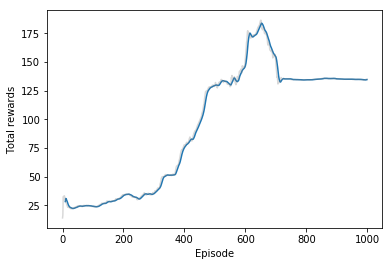

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

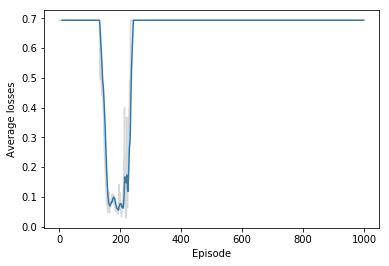

In [48]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.